## Description:

This file contains:
* **Explore 3 workflow options to see which gives least noise and best clustering**. Workflow options:
    * Opt-1: train on 7 days - predict upto 7 days includibg all past days
    * Opt-2: train on 7 days - predict 7 days without repeating articles
    * Opt-3: train on 7 days - predict 1 day at a time with retrained on past 7 days everytime (rolling window)
    
    
**Final Sukanya's thought processing**

| Option      | Technical correctness | Prod ease of use     |
| :---        |    :----:   |          :---: |
| Opt 1      | A bit short of correct because <br>borderline repeating articles (40%)<br> get unmatching topics <br> Noise % high    | Good - for trending yest and trending past week <br>1 article gets multiple topic <br>based on surrounding articles in given week.<br> So per week dashboard will be straightforward  |
| Opt 2   | Correct     <br> Noise % high   | Bad - for trending yest and trending past week <br> Would need topic standardization even for trending yest <br> because yest could get articles read from multiple past weeks <br> so article would have topics depending on what they were surrounded by in past weeks      |
| Opt 3   | Correct    <br> Noise % low   | Okayish - for trending yest. Bad for trending past week <br> Would need topic standardization only for trending past week as each day we can save all repeatings     |

* Day-over-day match rate -- Topics 82%, Noise - 50% both have same noise rest 50% - almost same gain/loss - seems borderline ones
* Training vs prediction match rate -- Topics - 90%, Noise - gaining more topics than losing. Common noise 50%

For the demo - Show:
* show above comparison - without rabbit hole
* introduce BQ table
* Yest trending, past week trending dashboards
* C-level vs Non-C-level topic grouping

### Why is prediction conservative in the first place?
May 3 predicted data:

* *without correction noise-reassign-to-closest-cluster*
    * seen/unseen rations
        * In train - got topic 0.56
        * In train - got noise **0.44**
        * Not in train - got topic 0.39
        * Not in train - got noise **0.61** --very bad 
    * When both have topics
        * 90% articles get same topic in training & prediction <br><br>
    * When either has noise
        * We are losing topics to noise articles way more than we are gaining during predicting on May3 i.e. 
        * training noise, pred non-noise -gained-186. pred noise, **training non-noise -lost-616**. Common noise 984

* *with correction noise-reassign-to-closest-cluster*
    * seen/unseen rations
        * In train - got topic 0.77
        * In train - got noise 0.23
        * Not in train - got topic 0.71
        * Not in train - got noise 0.29
    * When both have topics
        * 90% articles get same topic in training & prediction <br><br>
    * When either has noise
        * We are gaining topics on noise articles more than we are losing by predicting on May3 i.e. 
        * training noise, pred non-noise -gained-588. pred noise, training non-noise -lost-278. Common noise 582
        
**Verdict: There is def some prob in predict functionality. Mainly:**
* somehow training non-noise gets noised in prediction
    * even if we were to avoid this by not training on the seen ones again, the issue is -
* unseen data prediction is very bad i.e. 61% go to noise - very conservative
* also if prediction is just overlaying new points on old trained clsuters and assigning to relevant clusters, the presence or absence of other prediction points should not affect it (hypothesis). but we have seen - it does which is weird.

**Solution:**
Cosine similarity based treatment to recluster noise points was absolutely necessary and pretty helpful (as the with-treatment numbers show above)

In [1]:
""" Helper imports"""
import joblib
import pandas as pd
import numpy as np
from time import time
from nltk.tokenize import sent_tokenize
from joblib import Parallel, delayed
from sklearn.metrics.pairwise import cosine_similarity

"""Modeling imports"""
import umap
import hdbscan
from sentence_transformers import SentenceTransformer
from hdbscan import validity_index

""" Plotting imports"""
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

# remove this later
pd.set_option('max_colwidth', 110)
import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys
# add the parent directory path
sys.path.insert(0, '..')

from src.util import (c_tf_idf, 
                      extract_top_n_words_per_topic,
                      extract_topic_sizes,
                      topic_cos_sim_metrics,
                      generate_all_cossim_metrics)

In [3]:
data_path = '/home/jupyter/bi-topic-modeling/data/' 
results_path = '/home/jupyter/bi-topic-modeling/results/' 

SEED = 42

STOP_WORDS = pd.read_pickle(data_path + 'forbes_stop_words.pkl')
"q1" in STOP_WORDS

True

### --- Data ---

* Train date range Apr 26 (monday) till May 02 (sunday)
* Eligible pool = articles with pvs > 100 on a given day. In prod this will be replaced by pvs>350 summed over 7 days

In [4]:
def get_data(file_name):
    
    df = pd.read_csv(data_path + file_name)

    print("Before Shape:", df.shape)
    print("Unique tiers:", len(df.tier1.unique()))
    
    # Per verdict from EDA, exclude articles less than 100 words
    df["article_length"] = df.clean_body.str.split().apply(len)
    df = df[df["article_length"]>=100]
    print("After Shape:", df.shape)
    
    df.tier1 = df.tier1.fillna('Other')
    df = df.reset_index(drop=True)
    
    return df

In [5]:
# training data set

print("--- apr 25 ---")

apr25 = get_data('processed/train_apr25_over100pvs_processed.csv')
apr25_art_embed = joblib.load("./data/processed/apr25_article_embed_axis0.joblib")
print("Embeds len:", len(apr25_art_embed))

print()
print("--- apr 26 ---")

apr26 = get_data('processed/pred_apr26_over100pvs_processed.csv')
apr26_art_embed = joblib.load("./data/processed/apr26_article_embed_axis0.joblib")
print("Embeds len:", len(apr26_art_embed))

print()
print("--- apr 27 ---")

apr27 = get_data('processed/pred_apr27_over100pvs_processed.csv')
apr27_art_embed = joblib.load("./data/processed/apr27_article_embed_axis0.joblib")
print("Embeds len:", len(apr27_art_embed))

print()
print("--- apr 28 ---")

apr28 = get_data('processed/apr28_over100pvs_processed.csv')
apr28_art_embed = joblib.load("./data/processed/apr28_article_embed_axis0.joblib")
print("Embeds len:", len(apr28_art_embed))

print()
print("--- apr 29 ---")

apr29 = get_data('processed/apr29_over100pvs_processed.csv')
apr29_art_embed = joblib.load("./data/processed/apr29_article_embed_axis0.joblib")
print("Embeds len:", len(apr29_art_embed))

print()
print("--- apr 30 ---")

apr30 = get_data('processed/apr30_over100pvs_processed.csv')
apr30_art_embed = joblib.load("./data/processed/apr30_article_embed_axis0.joblib")
print("Embeds len:", len(apr30_art_embed))

print("--- may 01 ---")

may01 = get_data('processed/may01_over100pvs_processed.csv')
may01_art_embed = joblib.load("./data/processed/may01_article_embed_axis0.joblib")
print("Embeds len:", len(may01_art_embed))

print()
print("--- may 02 ---")

may02 = get_data('processed/may02_over100pvs_processed.csv')
may02_art_embed = joblib.load("./data/processed/may02_article_embed_axis0.joblib")
print("Embeds len:", len(may02_art_embed))

--- apr 25 ---
Before Shape: (3334, 10)
Unique tiers: 31
After Shape: (3327, 11)
Embeds len: 3327

--- apr 26 ---
Before Shape: (4138, 10)
Unique tiers: 31
After Shape: (4128, 11)
Embeds len: 4128

--- apr 27 ---
Before Shape: (4177, 10)
Unique tiers: 31
After Shape: (4167, 11)
Embeds len: 4167

--- apr 28 ---
Before Shape: (4197, 8)
Unique tiers: 31
After Shape: (4186, 9)
Embeds len: 4186

--- apr 29 ---
Before Shape: (4201, 8)
Unique tiers: 31
After Shape: (4188, 9)
Embeds len: 4188

--- apr 30 ---
Before Shape: (3784, 8)
Unique tiers: 31
After Shape: (3771, 9)
Embeds len: 3771
--- may 01 ---
Before Shape: (3052, 8)
Unique tiers: 31
After Shape: (3044, 9)
Embeds len: 3044

--- may 02 ---
Before Shape: (3267, 8)
Unique tiers: 31
After Shape: (3259, 9)
Embeds len: 3259


In [6]:
# testing data set

print()
print("--- may 03 ---")

may03 = get_data('processed/may03_over100pvs_processed.csv')
may03_art_embed = joblib.load("./data/processed/may03_article_embed_axis0.joblib")
print("Embeds len:", len(may03_art_embed))

print()
print("--- may 04 ---")

may04 = get_data('processed/may04_over100pvs_processed.csv')
may04_art_embed = joblib.load("./data/processed/may04_article_embed_axis0.joblib")
print("Embeds len:", len(may04_art_embed))

print()
print("--- may 05 ---")

may05 = get_data('processed/may05_over100pvs_processed.csv')
may05_art_embed = joblib.load("./data/processed/may05_article_embed_axis0.joblib")
print("Embeds len:", len(may05_art_embed))

print("--- may 06 ---")

may06 = get_data('processed/may06_over100pvs_processed.csv')
may06_art_embed = joblib.load("./data/processed/may06_article_embed_axis0.joblib")
print("Embeds len:", len(may06_art_embed))

print("--- may 07 ---")

may07 = get_data('processed/may07_over100pvs_processed.csv')
may07_art_embed = joblib.load("./data/processed/may07_article_embed_axis0.joblib")
print("Embeds len:", len(may07_art_embed))

print("--- may 08 ---")

may08 = get_data('processed/may08_over100pvs_processed.csv')
may08_art_embed = joblib.load("./data/processed/may08_article_embed_axis0.joblib")
print("Embeds len:", len(may08_art_embed))

print("--- may 09 ---")

may09 = get_data('processed/may09_over100pvs_processed.csv')
may09_art_embed = joblib.load("./data/processed/may09_article_embed_axis0.joblib")
print("Embeds len:", len(may09_art_embed))


--- may 03 ---
Before Shape: (4210, 8)
Unique tiers: 31
After Shape: (4199, 9)
Embeds len: 4199

--- may 04 ---
Before Shape: (4235, 8)
Unique tiers: 31
After Shape: (4223, 9)
Embeds len: 4223

--- may 05 ---
Before Shape: (4174, 8)
Unique tiers: 31
After Shape: (4160, 9)
Embeds len: 4160
--- may 06 ---
Before Shape: (4079, 8)
Unique tiers: 31
After Shape: (4063, 9)
Embeds len: 4063
--- may 07 ---
Before Shape: (3644, 8)
Unique tiers: 31
After Shape: (3630, 9)
Embeds len: 3630
--- may 08 ---
Before Shape: (3038, 8)
Unique tiers: 31
After Shape: (3025, 9)
Embeds len: 3025
--- may 09 ---
Before Shape: (3245, 8)
Unique tiers: 31
After Shape: (3231, 9)
Embeds len: 3231


# Opt-1 and Opt-2

### --- Combine train data - 7 days --- 
* apr 26 (monday) till may 2 (sunday)
* Observations on training clustering performance - same as the one in file shared for review

In [7]:
# concatenate dfs

combined_df = pd.concat([apr26, apr27, apr28, apr29, apr30, may01, may02])
# reset index
combined_df = combined_df.reset_index(drop=True)
# drop unnecessary cols
combined_df.drop(["processed", "processed_noun", "processed_noun_2"], axis = 1, inplace=True)
# fill na
combined_df.tier2 = combined_df.tier2.fillna('Other')
combined_df.total_timeonpage = combined_df.total_timeonpage.fillna(0)
print(combined_df.shape)

# concatenate embeds
combined_embeds = apr26_art_embed + apr27_art_embed + apr28_art_embed + apr29_art_embed + apr30_art_embed + may01_art_embed + may02_art_embed
print(len(combined_embeds))

(26743, 9)
26743


In [8]:
# drop duplicates from df

train_df = combined_df.drop_duplicates(subset="content_natid", keep='first')

print(train_df.shape)
print(train_df.content_natid.duplicated(keep='first').any())

train_embeds =  [combined_embeds[i] for i in list(train_df.index)]
print(len(train_embeds))

(7238, 9)
False
7238


In [9]:
train_df.reset_index(drop=True, inplace=True)

train_df = train_df[['content_natid', 'clean_body', 'tier1']]
train_df.shape

(7238, 3)

* Get train data metrics - 7 days: apr 26 (monday) till may 2 (sunday) per day metrics aggregated at natid (7 day) level

In [10]:
# get training data metrics
apr26_metrics = pd.read_csv(data_path + 'processed/apr26_metrics.csv')
apr27_metrics = pd.read_csv(data_path + 'processed/apr27_metrics.csv')
apr28_metrics = pd.read_csv(data_path + 'processed/apr28_metrics.csv')
apr29_metrics = pd.read_csv(data_path + 'processed/apr29_metrics.csv')
apr30_metrics = pd.read_csv(data_path + 'processed/apr30_metrics.csv')
may01_metrics = pd.read_csv(data_path + 'processed/may01_metrics.csv')
may02_metrics = pd.read_csv(data_path + 'processed/may02_metrics.csv')

combined_metrics = pd.concat([apr26_metrics, apr27_metrics, apr28_metrics, apr29_metrics, apr30_metrics, 
                              may01_metrics, may02_metrics])

apr26_may02_metrics = combined_metrics.groupby('GA_cmsNaturalId').agg({
    'pvs':'sum', 'avg_time_on_page':'mean', 'avg_scroll':'mean'
}).reset_index()

print(apr26_may02_metrics.shape)

(7522, 4)


### --- Modeling ---

In [11]:
data = train_df.clean_body.tolist()
print(len(data))

7238


**Param settings:** Newest -<br>

umap_embeddings =  umap.UMAP(n_neighbors=15,<br>
                             min_dist=0.0,<br>
                             n_components=2,<br>
                             random_state=SEED,<br>
                            ).fit(train_embeds)<br>
<br>
cluster = hdbscan.HDBSCAN(min_cluster_size=5,<br>
                      min_samples = 4, <br>
                      metric= 'euclidean',         
                      cluster_selection_method='eom',<br>
                      prediction_data=True).fit(umap_embeddings.embedding_)


In [13]:
# # NEW SETTINGS for lesser noise - umap:n_neighbors=15, n_components=2, min_dist=0.0 
# # hdbscan min_cluster_size=5, min_samples = 4, input = sentence embeddings aggregated (mean) to full article

# umap_embeddings =  umap.UMAP(n_neighbors=15,
#                              min_dist=0.0,
#                              n_components=2,
#                              random_state=SEED,
#                             ).fit(train_embeds)

In [14]:
# # cluster
# cluster = hdbscan.HDBSCAN(min_cluster_size=5,
#                       min_samples = 4, #new
#                       metric= 'euclidean',                      
#                       cluster_selection_method='eom',
#                       prediction_data=True).fit(umap_embeddings.embedding_)

In [12]:
# using HP-tuned params for comparing directly with 12a

best_cfg = (0.0, 12, 2, 5, 5)

print(best_cfg)

# dimensionality reduction
umap_embeddings =  umap.UMAP(min_dist = best_cfg[0],
                             n_neighbors = best_cfg[1],
                             n_components= best_cfg[2],
                             random_state=SEED,
                            ).fit(train_embeds)

# cluster
cluster = hdbscan.HDBSCAN(min_cluster_size= best_cfg[3],
                      min_samples = best_cfg[4],
                      metric= 'euclidean',                      
                      cluster_selection_method='eom',
                      prediction_data=True).fit(umap_embeddings.embedding_)

(0.0, 12, 2, 5, 5)


In [13]:
print("Shape of training embeddings:", umap_embeddings.embedding_.shape)

Shape of training embeddings: (7238, 2)


In [14]:
labels = cluster.labels_
print("Settings - mean axis=0")
validity_index(umap_embeddings.embedding_.astype('double'), labels)

Settings - mean axis=0


0.34083637100782105

In [15]:
# put topics in dataframe
docs_df = pd.DataFrame(data, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))

print("Distinct topics including -1 for noise", len(docs_df.Topic.unique()))
print()
docs_df

Distinct topics including -1 for noise 280



,Doc,Topic,Doc_ID
0,"10 robot vacuums that clean so you dont have to. if youre like most people, vacuuming is low on your list ...",-1,0
1,these 11 mattress toppers give you the bed of your dreams. while new pillows or a new set of sheets can do...,64,1
2,"wayfairs biggest sale of the year is officially here. thanks to the pandemic, most of us have spent the pa...",70,2
3,apple ios 14.5 released: massive iphone update with cool features & important fixes. april 28 update below...,60,3
4,apple airtag: all you need to know about the game-changing new gadget. april 28 update below. this post wa...,-1,4
...,...,...,...
7233,"the oilman, the playmate, and the tangled affairs of the billionaire marshall family. j. howard marshall i...",140,7233
7234,5 surprising foods that help you sleep. cherries: the new melatonin supplement (image via wikipedia) june ...,35,7234
7235,hacker's demo shows how easily credit cards can be read through clothes and wallets. some blank credit car...,31,7235
7236,"the five richest pastors in nigeria. london-based nigerian pastor matthew ashimolowo god is good, especial...",172,7236


In [16]:
# combine together all articles belonging to same cluster  
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

# calculate countVector and tf-idf
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(data))

# top n words, topic size
top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); 

# modify top_n_words per topic dict into dataframe for presentation
topic_words_dict = {}  

for k, v in top_n_words.items():
    topic_words_dict[k] = ", ".join([elem[0] for elem in v])

pd.set_option("max_colwidth", 250)
top_n_words_df = pd.DataFrame.from_dict(topic_words_dict, 
                                        orient='index').reset_index().rename(columns={'index':'topic_num',
                                                                                      
                                                                                      0:'topic_words'}) 

In [17]:
# clean keywords

from collections import OrderedDict
# from fuzzywuzzy import process, fuzz
from itertools import chain

import time
start = time.time()

clean_keys = []
for index, row in top_n_words_df.iterrows(): 
    
    # remove STOP WORDS and remove whitespaces
    inter_list = [x.strip() for x in row["topic_words"].split(",") if x not in STOP_WORDS]
    
    # remove numbers but not alphanumerics e.g. remove 400, not ps4 
    inter_list = [x for x in inter_list if not x.isnumeric()]
    
    # remove subset-based similar words - e.g. 'pcr tests' and 'tests' then 'tests' will be removed
    inter_list = [i for i in inter_list if not any(i in x and i!=x for x in inter_list)]

    # remove empty or 1-letter words
    inter_list = [x for x in inter_list if len(x)>1]
    
    # de-duplicate
    inter_list = list(OrderedDict.fromkeys(inter_list))
    
    # keep top 20 cleaned keywords
    inter_list = inter_list[:6] 
    
    # convert into string
    inter_list = ', '.join(inter_list)
    
    clean_keys.append(inter_list)

end = time.time()
print("keyword time", (end - start)/60) 

keyword time 0.0004695892333984375


In [18]:
top_n_words_df["topic_words"] = clean_keys

In [19]:
# GENERATE TOPIC METRICS

# per topic - cos_min and cos_mean
train_cossim_df = generate_all_cossim_metrics(docs_df, train_embeds)

# per topic - tier counts
tier_metric = docs_df.join(train_df[["tier1"]])

iab_metric = tier_metric.groupby("Topic").agg({"tier1": 
                                               'nunique'}).round(2).reset_index().rename(columns = {'tier1': 
                                                                                                    'distinct_tier1s',
                                                                                                    'Topic':
                                                                                                    'topic_num'})

# combine topic, top words, cos and tier metrics
topic_info = pd.merge(pd.merge(pd.merge(top_n_words_df, 
                               topic_sizes, how="inner", left_on="topic_num", right_on = "Topic"), 
                               train_cossim_df, on = "topic_num", how="inner"), 
                      iab_metric, on = "topic_num", how="inner")

topic_info.drop('Topic', axis=1, inplace=True)

In [20]:
topic_info.head()

,topic_num,topic_words,Size,cos_min,cos_mean,distinct_tier1s
0,-1,"coffee, age, china, government, leaders, women",2357,-0.03,0.72,31
1,0,"10 states, average annual, annual wage, salaries, occupational, therapist salary",34,0.77,0.90,8
2,1,"kentucky derby, essential quality, horses, churchill downs, race, triple crown",18,0.66,0.85,4
3,2,"million viewers, 000 viewers, fox news, msnbc, cable news, prime time",7,0.95,0.97,3
4,3,"packers, quarterback, round, rodgers, nfl draft, green bay",69,0.68,0.88,3


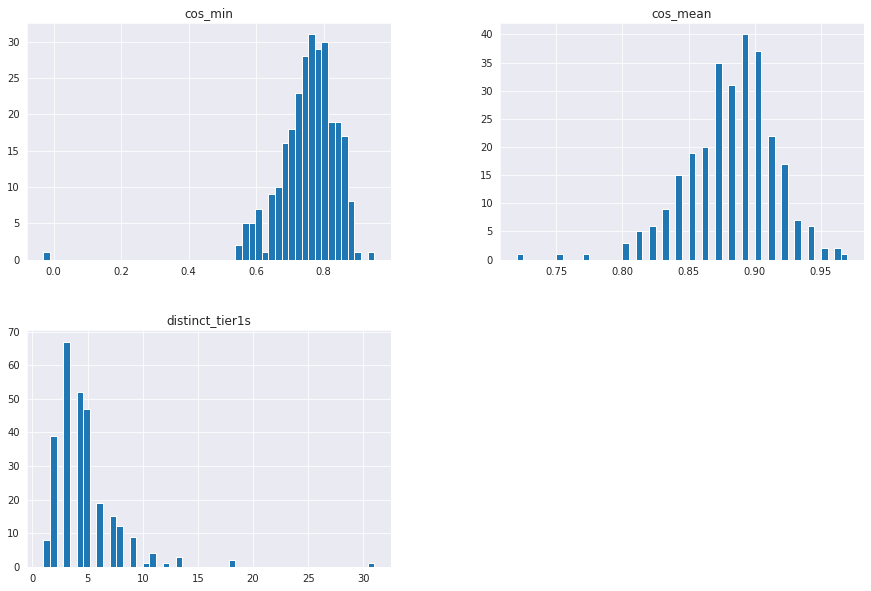

In [21]:
# TEST FOR LESSER NOISE
topic_info[['cos_min', 'cos_mean', 'distinct_tier1s']].hist(figsize= (15,10), bins=50)
plt.show()

In [22]:
topic_info[['cos_min', 'cos_mean', 'distinct_tier1s', 'Size']].describe().apply(lambda x: round(x, 3))

,cos_min,cos_mean,distinct_tier1s,Size
count,280.000,280.000,280.000,280.000
mean,0.755,0.879,4.636,25.850
std,0.091,0.034,3.003,140.567
min,-0.030,0.720,1.000,5.000
25%,0.710,0.860,3.000,8.000
50%,0.760,0.880,4.000,13.000
75%,0.810,0.900,5.000,22.000
max,0.950,0.970,31.000,2357.000


In [25]:
# joblib.dump(umap_embeddings, "./model/apr26_may2_train_umap_07192021.joblib")
# joblib.dump(cluster, "./model/apr26_may2_train_clusterer_07192021.joblib")

['./model/apr26_may2_train_clusterer_07192021.joblib']

**Topics are about:**


In [23]:
# combine natural id inside docs_df
docs_df = pd.merge(docs_df, train_df, how="left", left_on="Doc", right_on="clean_body")
docs_df.drop("clean_body", axis=1, inplace=True)

In [24]:
# contains natid, article body, assigned topic

full_train_topics = pd.merge(docs_df, topic_info, how="left", left_on="Topic", right_on="topic_num")
full_train_topics.head(1)

,Doc,Topic,Doc_ID,content_natid,tier1,topic_num,topic_words,Size,cos_min,cos_mean,distinct_tier1s
0,"10 robot vacuums that clean so you dont have to. if youre like most people, vacuuming is low on your list of favorite chores. you can avoid cleaning, or enlist the aid of a robot vacuum to clean your home autonomously. the best robot vacuums are ...",-1,0,blogandpostid/blog/post/4983-5ea87d15960ddf000681c604,Shopping,-1,"coffee, age, china, government, leaders, women",2357,-0.03,0.72,31


In [25]:
apr26_may02_metrics.head(3)

,GA_cmsNaturalId,pvs,avg_time_on_page,avg_scroll
0,blogandpostid/blog/post/1007-35894,678,185.901976,0.524951
1,blogandpostid/blog/post/1011-12712,103,90.669903,0.361650
2,blogandpostid/blog/post/1011-2227,134,99.514925,0.419776


In [26]:
final = pd.merge(full_train_topics, apr26_may02_metrics, left_on="content_natid", right_on="GA_cmsNaturalId", how="inner")
final.shape

(7238, 15)

In [27]:
final.isna().sum()

Doc                 0
Topic               0
Doc_ID              0
content_natid       0
tier1               0
topic_num           0
topic_words         0
Size                0
cos_min             0
cos_mean            0
distinct_tier1s     0
GA_cmsNaturalId     0
pvs                 0
avg_time_on_page    0
avg_scroll          3
dtype: int64

In [28]:
train_calcs = final.groupby('Topic').agg({'pvs':'sum', 'avg_time_on_page':'mean', 'avg_scroll':'mean',
                                        'content_natid':'nunique'}).reset_index()

train_calcs.sort_values("avg_time_on_page", ascending=False).head()

,Topic,pvs,avg_time_on_page,avg_scroll,content_natid
77,76,4481,186.355116,0.300981,8
274,273,10207,181.667873,0.435570,22
181,180,6063,178.787523,0.482136,12
11,10,58080,167.554650,0.361838,49
250,249,3023,167.381065,0.506866,7


In [29]:
# TEST FOR LESSER NOISE
# final.to_csv(results_path+"review_apr26_may02_trained_topics.csv", index=False)
# not saving again - refer to file shared for review for obs

* Noise

In [30]:
# data shared for review -- trained topics = 323. Noise = 27% (1946/7238)
# now -- trained topics = 328. Noise = 31% (2227/7238)

round(full_train_topics[full_train_topics.Topic==-1].shape[0]/full_train_topics.shape[0]*100)

33

In [31]:
topic_info[['Size', 'cos_min', 'cos_mean']].describe()

,Size,cos_min,cos_mean
count,280.000000,280.000000,280.000000
mean,25.850000,0.754643,0.879500
std,140.567102,0.090644,0.034419
min,5.000000,-0.030000,0.720000
25%,8.000000,0.710000,0.860000
50%,13.000000,0.760000,0.880000
75%,22.000000,0.810000,0.900000
max,2357.000000,0.950000,0.970000


### Opt-1 Prediction
* same model predict on 7 days with repeating articles

**Training data**

* Date range 7 days -- Apr 26 (monday) till May 02 (sunday)

* Eligible pool = articles with pvs threshold = 7,238 articles
    * **Distinct topics including -1 for noise :: 328**

**Prediction data**

* Date range -- may 3 (monday) till May 09 (friday)
* May 3 to May 9 repeating articles present
* Eligible pool = articles with pvs > 100

In [32]:
# umap_embeddings = joblib.load("./model/apr26_may2_train_umap_07192021.joblib")
# cluster = joblib.load("./model/apr26_may2_train_clusterer_07192021.joblib")

print(umap_embeddings)
print()
print(cluster)

UMAP(dens_frac=0.0, dens_lambda=0.0, min_dist=0.0, n_neighbors=12,
     random_state=42)

HDBSCAN(min_samples=5, prediction_data=True)


In [33]:
top_n_words_df.head()

,topic_num,topic_words
0,-1,"coffee, age, china, government, leaders, women"
1,0,"10 states, average annual, annual wage, salaries, occupational, therapist salary"
2,1,"kentucky derby, essential quality, horses, churchill downs, race, triple crown"
3,2,"million viewers, 000 viewers, fox news, msnbc, cable news, prime time"
4,3,"packers, quarterback, round, rodgers, nfl draft, green bay"


In [34]:
def predict(umap_embeddings, cluster, embed_list, pred_df):
    
    # dimensionality reduction
    pred_umap_embeddings = umap_embeddings.transform(embed_list)

    print("Training input shape:", umap_embeddings.embedding_.shape)
    print("Prediction input shape:", pred_umap_embeddings.shape) #takes a min
    print()
    
    # predict
    pred_test_labels, pred_strengths = hdbscan.approximate_predict(cluster, pred_umap_embeddings)
    
    # put topics in dataframe
    pred_docs_df = pred_df[['clean_body']]
    pred_docs_df.rename(columns={'clean_body':'Doc'}, inplace=True)
    pred_docs_df["Topic"] = pred_test_labels

    print("Distinct topics including -1 for noise", len(pred_docs_df.Topic.unique()))
    
    pred_topic_sizes = extract_topic_sizes(pred_docs_df)

    # GENERATE TOPIC METRICS

    # per topic - cos_min and cos_mean
    pred_cossim_df = generate_all_cossim_metrics(pred_docs_df, pred_umap_embeddings)

    # per topic - tier counts
    tier_metric = pred_docs_df.join(pred_df[["tier1"]])

    iab_metric = tier_metric.groupby("Topic").agg({"tier1": 
                                                   'nunique'}).round(2).reset_index().rename(columns = {'tier1': 
                                                                                                        'distinct_tier1s',
                                                                                                        'Topic':
                                                                                                        'topic_num'})

    # combine topic, top words, cos and tier metrics
    topic_info_pred = pd.merge(pd.merge(pred_topic_sizes, 
                                            pred_cossim_df, how="inner", left_on="Topic", right_on = "topic_num"), 
                                   iab_metric, on = "topic_num", how="inner")

    topic_info_pred.drop('Topic', axis=1, inplace=True)

    # combine topic_info with topic names

    topic_info_pred = pd.merge(topic_info_pred, top_n_words_df, how="left", on="topic_num").sort_values("topic_num")
    
    # combine natural id inside docs_df

    pred_docs_df = pd.merge(pred_docs_df, pred_df, how="left", left_on="Doc", right_on="clean_body")
    pred_docs_df.drop("clean_body", axis=1, inplace=True)
    
    pred_full = pd.merge(pred_docs_df, 
         topic_info_pred, 
         how="left", 
         left_on="Topic", 
         right_on = "topic_num").drop('topic_num', axis=1)
    
    return pred_full, pred_docs_df, topic_info_pred, pred_strengths

* **Predict new points/articles - May 3**

In [38]:
start = time.time()

pred_may03_full, may03_docs_df, topic_info_may03, may03_strengths = predict(umap_embeddings, cluster, 
                                                                            may03_art_embed, may03) 

# NOISE
print("Rows: ", pred_may03_full[pred_may03_full.Topic==-1].shape)
print("Perc: ", round(pred_may03_full[pred_may03_full.Topic==-1].shape[0]/pred_may03_full.shape[0] * 100))

end = time.time()

print()
print("time (mins): ", round((end - start)/60, 2)) 

topic_info_may03[['cos_min', 'cos_mean', 'distinct_tier1s', 'Size']].describe().apply(lambda x: round(x, 2))

Training input shape: (7238, 2)
Prediction input shape: (4199, 2)

Distinct topics including -1 for noise 310
Rows:  (1784, 15)
Perc:  42

time (mins):  0.13


,cos_min,cos_mean,distinct_tier1s,Size
count,286.00,286.00,310.00,310.00
mean,1.00,1.00,3.04,13.55
std,0.04,0.00,2.37,101.23
min,0.37,0.95,1.00,1.00
25%,1.00,1.00,2.00,3.00
50%,1.00,1.00,3.00,5.00
75%,1.00,1.00,4.00,9.00
max,1.00,1.00,31.00,1784.00


In [35]:
start = time.time()

pred_may03_full, may03_docs_df, topic_info_may03, may03_strengths = predict(umap_embeddings, cluster, 
                                                                            may03_art_embed, may03) 

# NOISE
print("Rows: ", pred_may03_full[pred_may03_full.Topic==-1].shape)
print("Perc: ", round(pred_may03_full[pred_may03_full.Topic==-1].shape[0]/pred_may03_full.shape[0] * 100))

end = time.time()

print()
print("time (mins): ", round((end - start)/60, 2)) 

topic_info_may03[['cos_min', 'cos_mean', 'distinct_tier1s', 'Size']].describe().apply(lambda x: round(x, 2))

Training input shape: (7238, 2)
Prediction input shape: (4199, 2)

Distinct topics including -1 for noise 267
Rows:  (1920, 15)
Perc:  46

time (mins):  0.31


,cos_min,cos_mean,distinct_tier1s,Size
count,245.00,245.00,267.00,267.00
mean,1.00,1.00,3.10,15.73
std,0.05,0.00,2.55,117.27
min,0.16,0.95,1.00,1.00
25%,1.00,1.00,2.00,3.00
50%,1.00,1.00,3.00,6.00
75%,1.00,1.00,4.00,11.00
max,1.00,1.00,31.00,1920.00


In [39]:
m3_in_train = pred_may03_full[pred_may03_full.content_natid.isin(full_train_topics.content_natid)]
m3_not_in_train = pred_may03_full[~pred_may03_full.content_natid.isin(full_train_topics.content_natid)]

print(pred_may03_full.shape)
print(m3_in_train.shape)
print(m3_not_in_train.shape)

print()

print("% Repeating from training", round(m3_in_train.shape[0]/pred_may03_full.shape[0], 2))
print("% Repeating from training", round(m3_not_in_train.shape[0]/pred_may03_full.shape[0], 2))

(4199, 15)
(3672, 15)
(527, 15)

% Repeating from training 0.87
% Repeating from training 0.13


In [40]:
print("In train - got topic", round(m3_in_train[m3_in_train.Topic!=-1].shape[0]/m3_in_train.shape[0], 2))
print("In train - got noise", round(m3_in_train[m3_in_train.Topic==-1].shape[0]/m3_in_train.shape[0], 2))

In train - got topic 0.56
In train - got noise 0.44


In [41]:
print("Not in train - got topic", round(m3_not_in_train[m3_not_in_train.Topic!=-1].shape[0]/m3_not_in_train.shape[0], 2))
print("Not in train - got noise", round(m3_not_in_train[m3_not_in_train.Topic==-1].shape[0]/m3_not_in_train.shape[0], 2))

Not in train - got topic 0.39
Not in train - got noise 0.61


In [45]:
col= ['content_natid', 'Doc', 'Topic', 'topic_words']

m3_train = pd.merge(pred_may03_full[col], full_train_topics[col], on="content_natid", how="inner")
m3_train.shape

(3672, 7)

In [50]:
full_train_topics[full_train_topics.Topic==-1].shape

(2357, 11)

In [46]:
print("common - both have topics", m3_train[(m3_train.Topic_x != -1) & (m3_train.Topic_y != -1)].shape)
print("common - training noise, pred noise", m3_train[(m3_train.Topic_x != -1) & (m3_train.Topic_y != -1) 
                                                      & (m3_train.Topic_x == m3_train.Topic_y)].shape, round(1989/2224, 2))

print("common - training noise, pred noise", m3_train[(m3_train.Topic_x != -1) & (m3_train.Topic_y != -1) 
                                                      & (m3_train.Topic_x != m3_train.Topic_y)].shape, round(235/2224, 2))

common - both have topics (1886, 7)
common - training noise, pred noise (1793, 7) 0.89
common - training noise, pred noise (93, 7) 0.11


In [48]:
print("either has noise",  m3_train[(m3_train.Topic_x == -1) | (m3_train.Topic_y == -1)].shape)

print("common - training noise", m3_train[m3_train.Topic_y==-1].shape)
print("common - training noise, pred non-noise", m3_train[(m3_train.Topic_x != -1) & (m3_train.Topic_y == -1)].shape)
print("common - training noise, pred noise", m3_train[(m3_train.Topic_x == -1) & (m3_train.Topic_y == -1)].shape)

either has noise (1786, 7)
common - training noise (1170, 7)
common - training noise, pred non-noise (186, 7)
common - training noise, pred noise (984, 7)


In [49]:
print("common - may 3 pred noise", m3_train[m3_train.Topic_x==-1].shape)
print("common - may 3 pred noise, training non-noise", m3_train[(m3_train.Topic_x == -1) & (m3_train.Topic_y != -1)].shape)
print("common - may 3 pred noise, training noise", m3_train[(m3_train.Topic_x == -1) & (m3_train.Topic_y == -1)].shape)

common - may 3 pred noise (1600, 7)
common - may 3 pred noise, training non-noise (616, 7)
common - may 3 pred noise, training noise (984, 7)


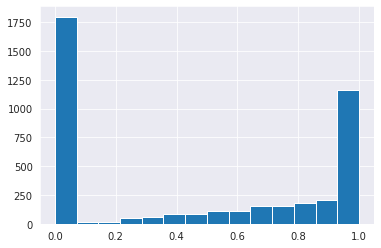

In [39]:
plt.hist(may03_strengths, bins='auto')
plt.show()

* **Predict new points/articles - May 04**

In [40]:
start = time.time()

pred_may04_full, may04_docs_df, topic_info_may04, may04_strengths = predict(umap_embeddings, cluster, 
                                                                            may04_art_embed, may04) 

# NOISE
print("Rows: ", pred_may04_full[pred_may04_full.Topic==-1].shape)
print("Perc: ", round(pred_may04_full[pred_may04_full.Topic==-1].shape[0]/pred_may04_full.shape[0] * 100))

end = time.time()
print("time (mins): ", round((end - start)/60, 2)) 

Training input shape: (7238, 2)
Prediction input shape: (4223, 2)

Distinct topics including -1 for noise 298
Rows:  (1964, 15)
Perc:  47
time (mins):  0.14


* **Predict new points/articles - May 05**

In [41]:
start = time.time()

pred_may05_full, may05_docs_df, topic_info_may05, may05_strengths = predict(umap_embeddings, cluster, 
                                                                            may05_art_embed, may05) 

# NOISE
print("Rows: ", pred_may05_full[pred_may05_full.Topic==-1].shape)
print("Perc: ", round(pred_may05_full[pred_may05_full.Topic==-1].shape[0]/pred_may05_full.shape[0] * 100))

end = time.time()
print("time (mins): ", round((end - start)/60, 2)) 

topic_info_may05[['cos_min', 'cos_mean', 'distinct_tier1s', 'Size']].describe().apply(lambda x: round(x, 2))

Training input shape: (7238, 2)
Prediction input shape: (4160, 2)

Distinct topics including -1 for noise 311
Rows:  (1797, 15)
Perc:  43
time (mins):  0.12


,cos_min,cos_mean,distinct_tier1s,Size
count,269.00,269.00,311.00,311.00
mean,1.00,1.00,3.04,13.38
std,0.04,0.00,2.48,101.81
min,0.35,0.95,1.00,1.00
25%,1.00,1.00,2.00,3.00
50%,1.00,1.00,3.00,5.00
75%,1.00,1.00,4.00,9.00
max,1.00,1.00,31.00,1797.00


* **Predict new points/articles - May 06**

In [42]:
start = time.time()

pred_may06_full, may06_docs_df, topic_info_may06, may06_strengths = predict(umap_embeddings, cluster, 
                                                                            may06_art_embed, may06) 

# NOISE
print("Rows: ", pred_may06_full[pred_may06_full.Topic==-1].shape)
print("Perc: ", round(pred_may06_full[pred_may06_full.Topic==-1].shape[0]/pred_may06_full.shape[0] * 100))

end = time.time()
print("time (mins): ", round((end - start)/60, 2)) 

topic_info_may06[['cos_min', 'cos_mean', 'distinct_tier1s', 'Size']].describe().apply(lambda x: round(x, 2))

Training input shape: (7238, 2)
Prediction input shape: (4063, 2)

Distinct topics including -1 for noise 292
Rows:  (1950, 15)
Perc:  48
time (mins):  0.13


,cos_min,cos_mean,distinct_tier1s,Size
count,247.00,247.00,292.00,292.00
mean,1.00,1.00,3.01,13.91
std,0.04,0.00,2.51,113.95
min,0.34,0.94,1.00,1.00
25%,1.00,1.00,1.00,2.00
50%,1.00,1.00,3.00,5.00
75%,1.00,1.00,4.00,9.25
max,1.00,1.00,31.00,1950.00


* **Predict new points/articles - May 07**

In [43]:
start = time.time()

pred_may07_full, may07_docs_df, topic_info_may07, may07_strengths = predict(umap_embeddings, cluster, 
                                                                            may07_art_embed, may07) 

# NOISE
print("Rows: ", pred_may07_full[pred_may07_full.Topic==-1].shape)
print("Perc: ", round(pred_may07_full[pred_may07_full.Topic==-1].shape[0]/pred_may07_full.shape[0] * 100))

end = time.time()
print("time (mins): ", round((end - start)/60, 2)) 

topic_info_may07[['cos_min', 'cos_mean', 'distinct_tier1s', 'Size']].describe().apply(lambda x: round(x, 2))

Training input shape: (7238, 2)
Prediction input shape: (3630, 2)

Distinct topics including -1 for noise 287
Rows:  (1676, 15)
Perc:  46
time (mins):  0.13


,cos_min,cos_mean,distinct_tier1s,Size
count,244.00,244.00,287.00,287.00
mean,1.00,1.00,2.89,12.65
std,0.04,0.00,2.41,98.79
min,0.32,0.94,1.00,1.00
25%,1.00,1.00,1.00,2.00
50%,1.00,1.00,2.00,5.00
75%,1.00,1.00,4.00,8.00
max,1.00,1.00,30.00,1676.00


* **Predict new points/articles - May 08**

In [44]:
start = time.time()

pred_may08_full, may08_docs_df, topic_info_may08, may08_strengths = predict(umap_embeddings, cluster, 
                                                                            may08_art_embed, may08) 

# NOISE
print("Rows: ", pred_may08_full[pred_may08_full.Topic==-1].shape)
print("Perc: ", round(pred_may08_full[pred_may08_full.Topic==-1].shape[0]/pred_may08_full.shape[0] * 100))

end = time.time()
print("time (mins): ", round((end - start)/60, 2)) 

topic_info_may08[['cos_min', 'cos_mean', 'distinct_tier1s', 'Size']].describe().apply(lambda x: round(x, 2))

Training input shape: (7238, 2)
Prediction input shape: (3025, 2)

Distinct topics including -1 for noise 277
Rows:  (1379, 15)
Perc:  46
time (mins):  0.11


,cos_min,cos_mean,distinct_tier1s,Size
count,218.00,218.00,277.00,277.00
mean,1.00,1.00,2.66,10.92
std,0.04,0.00,2.30,82.77
min,0.36,0.94,1.00,1.00
25%,1.00,1.00,1.00,2.00
50%,1.00,1.00,2.00,4.00
75%,1.00,1.00,3.00,7.00
max,1.00,1.00,29.00,1379.00


* **Predict new points/articles - May 09**

In [45]:
start = time.time()

pred_may09_full, may09_docs_df, topic_info_may09, may09_strengths = predict(umap_embeddings, cluster, 
                                                                            may09_art_embed, may09) 

# NOISE
print("Rows: ", pred_may09_full[pred_may09_full.Topic==-1].shape)
print("Perc: ", round(pred_may09_full[pred_may09_full.Topic==-1].shape[0]/pred_may09_full.shape[0] * 100))

end = time.time()
print("time (mins): ", round((end - start)/60, 2)) 

topic_info_may09[['cos_min', 'cos_mean', 'distinct_tier1s', 'Size']].describe().apply(lambda x: round(x, 2))

Training input shape: (7238, 2)
Prediction input shape: (3231, 2)

Distinct topics including -1 for noise 281
Rows:  (1509, 15)
Perc:  47
time (mins):  0.11


,cos_min,cos_mean,distinct_tier1s,Size
count,229.00,229.00,281.00,281.00
mean,1.00,1.00,2.69,11.50
std,0.04,0.00,2.37,89.91
min,0.35,0.94,1.00,1.00
25%,1.00,1.00,1.00,2.00
50%,1.00,1.00,2.00,4.00
75%,1.00,1.00,3.00,8.00
max,1.00,1.00,31.00,1509.00


In [46]:
# **Note:** 
# * There will be articles read between Apr 26 - May 02 (training set), which will also be read on May 03. 
# * These common articles present in prediction set, will get the same topic cluster as before

# **For now:**
# * Predict on whole of may03

# --- EDA ---

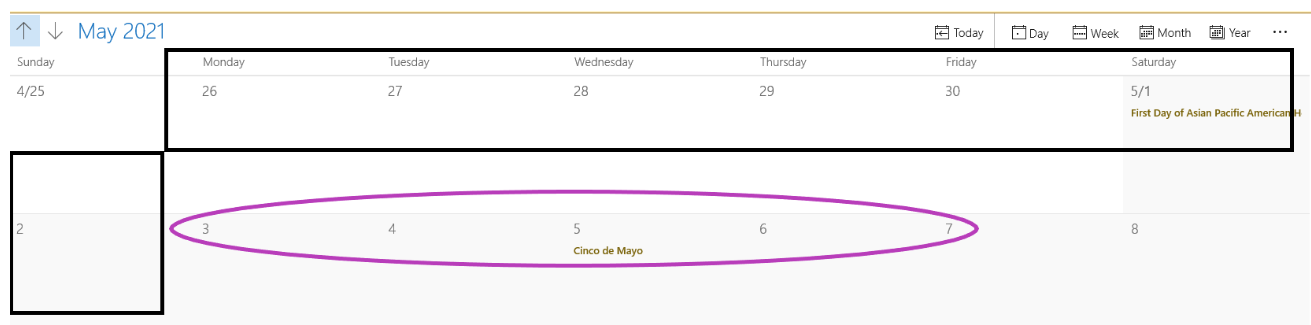

In [47]:
print("Eligible articles:")
print("May 3 -", pred_may03_full.shape)
print("May 4 -", pred_may04_full.shape)
print("May 5 -", pred_may05_full.shape)
print("May 6 -", pred_may06_full.shape)
print("May 7 -", pred_may07_full.shape)
print("May 8 -", pred_may08_full.shape)
print("May 9 -", pred_may09_full.shape)

Eligible articles:
May 3 - (4199, 15)
May 4 - (4223, 15)
May 5 - (4160, 15)
May 6 - (4063, 15)
May 7 - (3630, 15)
May 8 - (3025, 15)
May 9 - (3231, 15)


In [48]:
print("Number of Topics assigned:")
print("May 3 -",len(pred_may03_full.Topic.unique()))
print("May 4 -",len(pred_may04_full.Topic.unique()))
print("May 5 -",len(pred_may05_full.Topic.unique()))
print("May 6 -",len(pred_may06_full.Topic.unique()))
print("May 7 -",len(pred_may07_full.Topic.unique()))
print("May 8 -",len(pred_may08_full.Topic.unique()))
print("May 9 -",len(pred_may09_full.Topic.unique()))

Number of Topics assigned:
May 3 - 310
May 4 - 298
May 5 - 311
May 6 - 292
May 7 - 287
May 8 - 277
May 9 - 281


In [49]:
print("Avg topic size:")
print("May 3 -",round(topic_info_may03.Size.mean()))
print("May 4 -",round(topic_info_may04.Size.mean()))
print("May 5 -",round(topic_info_may05.Size.mean()))
print("May 6 -",round(topic_info_may06.Size.mean()))
print("May 7 -",round(topic_info_may07.Size.mean()))
print("May 8 -",round(topic_info_may08.Size.mean()))
print("May 9 -",round(topic_info_may09.Size.mean()))

Avg topic size:
May 3 - 14
May 4 - 14
May 5 - 13
May 6 - 14
May 7 - 13
May 8 - 11
May 9 - 11


**Observation:**
* On avg. 9 articles form a topic

In [50]:
common_5 = pd.merge(pd.merge(pd.merge(pd.merge(topic_info_may03[["topic_num"]], 
                                                topic_info_may04[["topic_num"]], on="topic_num", how="inner"), 
                                       topic_info_may05[["topic_num"]], on="topic_num", how="inner"), 
                     topic_info_may06[["topic_num"]], on="topic_num", how="inner"), 
                     topic_info_may07[["topic_num"]], on="topic_num", how="inner")

print("Common topics across 5 days - ", len(common_5))

Common topics across 5 days -  258


In [51]:
common_7 =  pd.merge(pd.merge(pd.merge(pd.merge(pd.merge(pd.merge(topic_info_may03[["topic_num"]], 
                                                topic_info_may04[["topic_num"]], on="topic_num", how="inner"), 
                                       topic_info_may05[["topic_num"]], on="topic_num", how="inner"), 
                     topic_info_may06[["topic_num"]], on="topic_num", how="inner"), 
                     topic_info_may07[["topic_num"]], on="topic_num", how="inner"), 
                     topic_info_may08[["topic_num"]], on="topic_num", how="inner"), 
                     topic_info_may09[["topic_num"]], on="topic_num", how="inner")

print("Common topics across 5 days - ", len(common_7))

Common topics across 5 days -  236


In [52]:
topic_info_may03 #[["topic_num"]]

,Size,topic_num,cos_min,cos_mean,distinct_tier1s,topic_words
0,1784,-1,0.37,0.95,31,"remote, age, businesses, leaders, workers, water"
8,29,0,1.00,1.00,7,"10 states, average annual, annual wage, salaries, occupational, therapist salary"
165,5,1,1.00,1.00,3,"million viewers, 000 viewers, fox news, msnbc, cable news, prime time"
54,12,2,1.00,1.00,4,"pink moon, sky, supermoons, super pink, sun, blood moon"
91,8,3,1.00,1.00,3,"def, aew, nxt, wrestlemania, smackdown, live events"
...,...,...,...,...,...,...
173,5,316,1.00,1.00,2,"kabat zinn, mindfulness, ikigai, kelly, decisions, goal setting"
239,3,317,1.00,1.00,2,"conflict, happiness, nonverbal cues, gestures, strategic thinkers, body language"
292,1,318,NaN,NaN,1,"coachable, unspoken rules, communicators, ask, ng, leadership"
71,10,319,1.00,1.00,5,"overthinking, psychological safety, smart people, feelings, emotions, therapy"


In [53]:
topic_info_may04

,Size,topic_num,cos_min,cos_mean,distinct_tier1s,topic_words
0,1964,-1,0.36,0.94,31,"remote, age, businesses, leaders, workers, water"
7,33,0,1.00,1.00,7,"10 states, average annual, annual wage, salaries, occupational, therapist salary"
90,8,1,1.00,1.00,4,"million viewers, 000 viewers, fox news, msnbc, cable news, prime time"
67,10,2,1.00,1.00,4,"pink moon, sky, supermoons, super pink, sun, blood moon"
81,9,3,1.00,1.00,3,"def, aew, nxt, wrestlemania, smackdown, live events"
...,...,...,...,...,...,...
185,3,313,1.00,1.00,1,"new job, job search, counteroffer, hiring manager, boss, script"
269,1,314,NaN,NaN,1,"sign toxic, toxic culture, resume, kh, manager, bullying"
241,2,318,1.00,1.00,2,"coachable, unspoken rules, communicators, ask, ng, leadership"
260,1,319,NaN,NaN,1,"overthinking, psychological safety, smart people, feelings, emotions, therapy"


In [54]:
print("Eligible articles:")
print("May 3 -", pred_may03_full.shape)
print("May 4 -", pred_may04_full.shape)
print("May 5 -", pred_may05_full.shape)
print("May 6  -", pred_may06_full.shape)
print("May 7 -", pred_may07_full.shape)
print("May 8 -", pred_may08_full.shape)
print("May 9 -", pred_may09_full.shape)

Eligible articles:
May 3 - (4199, 15)
May 4 - (4223, 15)
May 5 - (4160, 15)
May 6 - (4063, 15)
May 7 - (3630, 15)
May 8 - (3025, 15)
May 9 - (3231, 15)


In [55]:
common_articles = pd.merge(pd.merge(pd.merge(pd.merge(pred_may03_full[["content_natid", "Topic", "topic_words"]], 
                                                pred_may04_full[["content_natid", "Topic", "topic_words"]], on="content_natid", how="inner"), 
                                       pred_may05_full[["content_natid", "Topic", "topic_words"]], on="content_natid", how="inner"), 
                     pred_may06_full[["content_natid", "Topic", "topic_words"]], on="content_natid", how="inner"), 
                     pred_may07_full[["content_natid", "Topic", "topic_words"]], on="content_natid", how="inner")

print("Common topics across 5 days - ", len(common_articles))

Common topics across 5 days -  2323


In [95]:
common_7

,topic_num
0,-1
1,0
2,1
3,2
4,3
...,...
231,304
232,307
233,308
234,309


### Noise Comparison 

**Observation:**
* On avg. 50% - 54% articles get clustered into a topic each day and rest is deemed as noise by HDBSCAN 

In [51]:
print("# of articles NOISE - ")
print("May 3 -",round(pred_may03_full[pred_may03_full.Topic==-1].shape[0]))
print("May 4 -",round(pred_may04_full[pred_may04_full.Topic==-1].shape[0]))
print("May 5 -",round(pred_may05_full[pred_may05_full.Topic==-1].shape[0]))
print("May 6 -",round(pred_may06_full[pred_may06_full.Topic==-1].shape[0]))
print("May 7 -",round(pred_may07_full[pred_may07_full.Topic==-1].shape[0]))
print("May 8 -",round(pred_may08_full[pred_may08_full.Topic==-1].shape[0]))
print("May 9 -",round(pred_may09_full[pred_may09_full.Topic==-1].shape[0]))

# of articles NOISE - 
May 3 - 1784
May 4 - 1964
May 5 - 1797
May 6 - 1950
May 7 - 1676
May 8 - 1379
May 9 - 1509


In [52]:
print("Perc of articles NOISE - ")
print("May 3 -",round(pred_may03_full[pred_may03_full.Topic==-1].shape[0]/pred_may03_full.shape[0]*100))
print("May 4 -",round(pred_may04_full[pred_may04_full.Topic==-1].shape[0]/pred_may04_full.shape[0]*100))
print("May 5 -",round(pred_may05_full[pred_may05_full.Topic==-1].shape[0]/pred_may05_full.shape[0]*100))
print("May 6 -",round(pred_may06_full[pred_may06_full.Topic==-1].shape[0]/pred_may06_full.shape[0]*100))
print("May 7 -",round(pred_may07_full[pred_may07_full.Topic==-1].shape[0]/pred_may07_full.shape[0]*100))
print("May 8 -",round(pred_may08_full[pred_may08_full.Topic==-1].shape[0]/pred_may08_full.shape[0]*100))
print("May 9 -",round(pred_may09_full[pred_may09_full.Topic==-1].shape[0]/pred_may09_full.shape[0]*100))

Perc of articles NOISE - 
May 3 - 42
May 4 - 47
May 5 - 43
May 6 - 48
May 7 - 46
May 8 - 46
May 9 - 47


### Repeating articles Comparison 

**Observation:**
* If this were to be pursued, in prod - 
    * feed May03 noise (read on May 04) into eligible pool for next day's prediction -- no: higher prob that it will still be noise because of surrounding articles? Plus - now implemented a way to reassign noise to closest topic using cosine similarity
    * also May 04 noise had topics in May 03 so check the saved BQ table and lessen the actual noise -- no: now implemented a way to reassign noise to closest topic using cosine similarity

**-----Repeats-----**

In [55]:
# # old

# col_list = ['content_natid', 'Doc', 'Topic', 'topic_words']
# common_43 = pd.merge(pred_may03_full[col_list], pred_may04_full[col_list], how="inner", on="content_natid")
# common_43.shape
# # 81% of articles read on May 4 were also read on May 3

(3422, 7)

In [77]:
col_list = ['content_natid', 'Doc', 'Topic', 'topic_words']
# old
common_43 = pd.merge(pd.merge(pred_may03_full[col_list], 
                              pred_may04_full[col_list], how="inner", on="content_natid"),
                      full_train_topics[col_list], how="left", on="content_natid")
                     
print(common_43.shape)
print(common_43.columns)

(3422, 10)
Index(['content_natid', 'Doc_x', 'Topic_x', 'topic_words_x', 'Doc_y',
       'Topic_y', 'topic_words_y', 'Doc', 'Topic', 'topic_words'],
      dtype='object')


In [58]:
# # 69% repeating articles on May 4 have same topic as May 3
# print("Repeating article topic agreement: ", common_43[(common_43.Topic_x == common_43.Topic_y) & 
#                                                       (common_43.Topic_y == common_43.Topic)].shape)

Repeating article topic agreement:  (1681, 10)


In [61]:
# # 31% repeating articles on non-matchin topics on May 4 and May 3
# non_match_repeats = common_43[common_43.Topic_x != common_43.Topic_y]

# print("Repeating article topic non-agreement: ",non_match_repeats.shape)

# print("May 3 noise", non_match_repeats[non_match_repeats.Topic_x==-1].shape)
# print("May 4 noise", non_match_repeats[non_match_repeats.Topic_y==-1].shape)

# print(" --- All May 03 noise got a valid topic on May 04 ---")
# print(non_match_repeats[(non_match_repeats.Topic_x==-1) & (non_match_repeats.Topic_y!=-1)].shape)
# print()
# print(sorted(non_match_repeats[non_match_repeats.Topic_x==-1].Topic_y.unique()))

 --- All May 03 noise got a valid topic on May 04 ---
(440, 7)

[2, 4, 5, 9, 10, 11, 12, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 30, 31, 32, 36, 38, 39, 42, 43, 45, 47, 48, 50, 53, 54, 56, 57, 59, 60, 61, 62, 63, 65, 66, 67, 68, 70, 72, 74, 75, 78, 80, 81, 84, 85, 86, 89, 92, 93, 94, 95, 99, 100, 101, 102, 103, 105, 106, 107, 108, 111, 115, 117, 119, 121, 122, 123, 124, 126, 127, 128, 133, 134, 135, 136, 139, 141, 142, 143, 145, 148, 149, 150, 152, 154, 156, 159, 160, 161, 163, 164, 165, 166, 167, 168, 169, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 183, 184, 185, 188, 189, 190, 192, 196, 197, 198, 199, 200, 201, 202, 203, 205, 207, 209, 211, 212, 213, 214, 216, 219, 225, 227, 229, 233, 234, 235, 239, 240, 241, 243, 246, 247, 248, 250, 253, 254, 255, 258, 259, 260, 261, 262, 264, 265, 267, 268, 272, 273, 274, 275, 276, 277, 278, 281, 283, 284, 286, 287, 288, 290, 291, 294, 295, 296, 298, 300, 301, 302, 303, 306, 307, 310, 311, 315, 317, 318, 321, 322, 323, 324, 325, 326]


In [62]:
# print(" --- All May 04 noise had a valid topic on May 03 ---")
# print(non_match_repeats[(non_match_repeats.Topic_y==-1) & (non_match_repeats.Topic_x!=-1)].shape)
# print()
# print(sorted(non_match_repeats[non_match_repeats.Topic_y==-1].Topic_x.unique()))

 --- All May 04 noise had a valid topic on May 03 ---
(474, 7)

[2, 4, 5, 8, 10, 11, 15, 16, 17, 21, 22, 25, 26, 28, 30, 31, 33, 34, 36, 37, 38, 39, 41, 42, 48, 49, 52, 57, 58, 60, 64, 65, 67, 70, 72, 74, 75, 76, 77, 78, 79, 80, 81, 83, 85, 86, 87, 89, 90, 92, 93, 94, 95, 97, 98, 99, 100, 101, 102, 105, 106, 107, 108, 110, 111, 112, 115, 117, 118, 119, 121, 123, 127, 128, 129, 131, 133, 134, 135, 138, 139, 141, 145, 146, 150, 152, 153, 154, 155, 156, 157, 158, 159, 160, 162, 163, 164, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 185, 186, 187, 189, 190, 191, 192, 194, 195, 197, 198, 199, 200, 202, 203, 204, 205, 206, 207, 208, 209, 211, 213, 214, 217, 218, 219, 220, 221, 224, 227, 228, 229, 230, 231, 233, 234, 235, 237, 238, 240, 241, 243, 244, 245, 246, 247, 249, 250, 251, 252, 253, 254, 256, 258, 259, 260, 261, 264, 265, 267, 268, 272, 274, 275, 276, 277, 279, 281, 282, 284, 285, 286, 287, 288, 289, 290, 291, 293, 295, 296, 297, 298, 300, 

In [63]:
# print("May 3 & 4 non matching topics: ", 
#       non_match_repeats[(non_match_repeats.Topic_x!=-1) & (non_match_repeats.Topic_y!=-1)].shape)

May 3 & 4 non matching topics:  (156, 7)


In [64]:
# non_match_repeats.to_csv("may3_may4_nonmathcing_repeats.csv", index=False)

**-----Non-Repeats-----**

In [54]:
print(pred_may04_full.shape)
print(pred_may04_full[pred_may04_full.content_natid.isin(pred_may03_full.content_natid)].shape)
print(pred_may04_full[pred_may04_full.content_natid.isin(full_train_topics.content_natid)].shape)

(4223, 15)
(3422, 15)
(3350, 15)


In [68]:
# old
# unique_may4 = pred_may04_full[~pred_may04_full.content_natid.isin(pred_may03_full.content_natid)]
# unique_may4.shape

(801, 15)

In [55]:
# new
unique_may4 = pred_may04_full[~((pred_may04_full.content_natid.isin(full_train_topics.content_natid)) | (pred_may04_full.content_natid.isin(pred_may03_full.content_natid)))]
unique_may4.shape

(519, 15)

In [57]:
# print("Total noise in May4", pred_may04_full[pred_may04_full.Topic==-1].shape)
# print("Noise among repeating", common_43[common_43.Topic_y==-1].shape)
# print("Noise among non-repeating", unique_may4[unique_may4.Topic==-1].shape)

**-----Prediction vs Training exploration-----**

In [58]:
may4_noise = pred_may04_full[pred_may04_full.Topic==-1]
print(may4_noise.shape)
may4_noise_nonnoise = pred_may04_full[pred_may04_full.Topic!=-1]
print(may4_noise_nonnoise.shape)

(2033, 15)
(2190, 15)


In [59]:
print(may4_noise_nonnoise[may4_noise_nonnoise.content_natid.isin(full_train_topics.content_natid)].shape[0])
print(may4_noise_nonnoise[may4_noise_nonnoise.content_natid.isin(full_train_topics.content_natid)].shape[0]/may4_noise_nonnoise.shape[0])

1805
0.8242009132420092


In [60]:
print(may4_noise_nonnoise[~may4_noise_nonnoise.content_natid.isin(full_train_topics.content_natid)].shape[0])
print(may4_noise_nonnoise[~may4_noise_nonnoise.content_natid.isin(full_train_topics.content_natid)].shape[0]/may4_noise_nonnoise.shape[0])

385
0.17579908675799086


In [61]:
print(may4_noise[may4_noise.content_natid.isin(full_train_topics.content_natid)].shape[0])
print(may4_noise[may4_noise.content_natid.isin(full_train_topics.content_natid)].shape[0]/may4_noise.shape[0])

1545
0.7599606492867683


In [62]:
print(may4_noise[~may4_noise.content_natid.isin(full_train_topics.content_natid)].shape[0])
print(may4_noise[~may4_noise.content_natid.isin(full_train_topics.content_natid)].shape[0]/may4_noise.shape[0])

488
0.24003935071323168


**-----Non-Repeats detailed exploration-----**

In [63]:
unique_may4.shape

(519, 15)

In [64]:
unique_may4_nonnoise = unique_may4[unique_may4.Topic!=-1]
print(unique_may4_nonnoise.shape[0])
print(unique_may4_nonnoise.shape[0]/unique_may4.shape[0])

223
0.4296724470134875


In [65]:
unique_may4_noise = unique_may4[unique_may4.Topic==-1]
print(unique_may4_noise.shape[0])
print(unique_may4_noise.shape[0]/unique_may4.shape[0])

296
0.5703275529865125


In [66]:
print(unique_may4[unique_may4.content_natid.isin(full_train_topics.content_natid)].shape[0])
print(unique_may4[unique_may4.content_natid.isin(full_train_topics.content_natid)].shape[0]/unique_may4.shape[0])

0
0.0


In [67]:
print(unique_may4_nonnoise[unique_may4_nonnoise.content_natid.isin(full_train_topics.content_natid)].shape[0])
print(unique_may4_nonnoise[unique_may4_nonnoise.content_natid.isin(full_train_topics.content_natid)].shape[0]/unique_may4_nonnoise.shape[0])

0
0.0


In [68]:
print(unique_may4_nonnoise[~unique_may4_nonnoise.content_natid.isin(full_train_topics.content_natid)].shape[0])
print(unique_may4_nonnoise[~unique_may4_nonnoise.content_natid.isin(full_train_topics.content_natid)].shape[0]/unique_may4_nonnoise.shape[0])

223
1.0


In [83]:
# out of noise, 30% were in training data as well. 
print(unique_may4_noise[unique_may4_noise.content_natid.isin(full_train_topics.content_natid)].shape[0])
print(unique_may4_noise[unique_may4_noise.content_natid.isin(full_train_topics.content_natid)].shape[0]/unique_may4_noise.shape[0])
print(unique_may4_noise[~unique_may4_noise.content_natid.isin(full_train_topics.content_natid)].shape[0])
print(unique_may4_noise[~unique_may4_noise.content_natid.isin(full_train_topics.content_natid)].shape[0]/unique_may4_noise.shape[0])

0
0.0
296
1.0


In [69]:
common_unique_may4_noise_train = pd.merge(unique_may4_noise[['content_natid', 'Doc', 'Topic', 'topic_words']], 
                                          full_train_topics[['content_natid', 'Doc', 'Topic', 'topic_words']], on="content_natid", how="inner")
common_unique_may4_noise_train.shape

(0, 7)

In [70]:
print(common_unique_may4_noise_train[(common_unique_may4_noise_train.Topic_x==-1) & (common_unique_may4_noise_train.Topic_y==-1)].shape)
print(common_unique_may4_noise_train[((common_unique_may4_noise_train.Topic_x==-1) & (common_unique_may4_noise_train.Topic_y!=-1))].shape)

(0, 7)
(0, 7)


In [71]:
non_unique_commons = pred_may04_full[~pred_may04_full.content_natid.isin(unique_may4.content_natid)]
non_unique_commons.shape

(3704, 15)

In [72]:
col_list = ['content_natid', 'Doc', 'Topic', 'topic_words']

common_43 = pd.merge(pd.merge(non_unique_commons[col_list], 
                              pred_may03_full[col_list], how="left", on="content_natid"),
                      full_train_topics[col_list], how="left", on="content_natid")
                     
print(common_43.shape)
print(common_43.columns)

(3704, 10)
Index(['content_natid', 'Doc_x', 'Topic_x', 'topic_words_x', 'Doc_y',
       'Topic_y', 'topic_words_y', 'Doc', 'Topic', 'topic_words'],
      dtype='object')


In [73]:
col_list = ['content_natid', 'Doc', 'Topic', 'topic_words']

common_4train = pd.merge(non_unique_commons[col_list], 
                      full_train_topics[col_list], how="inner", on="content_natid")
                     
print(common_4train.shape)
print(common_4train.columns)

(3350, 7)
Index(['content_natid', 'Doc_x', 'Topic_x', 'topic_words_x', 'Doc_y',
       'Topic_y', 'topic_words_y'],
      dtype='object')


In [74]:
print(common_4train.shape)
print(common_4train[(common_4train.Topic_x==common_4train.Topic_y)].shape)
print(common_4train[(common_4train.Topic_x==-1) & (common_4train.Topic_y==-1)].shape)
print(common_4train[(common_4train.Topic_x!=-1) & (common_4train.Topic_y!=-1) & (common_4train.Topic_x==common_4train.Topic_y)].shape)

(3350, 7)
(2171, 7)
(797, 7)
(1374, 7)


In [75]:
print(common_4train[(common_4train.Topic_x!= common_4train.Topic_y)].shape)
print(common_4train[(common_4train.Topic_x==-1) & (common_4train.Topic_y!=-1)].shape)
print(common_4train[(common_4train.Topic_x!=-1) & (common_4train.Topic_y==-1)].shape)
print(common_4train[(common_4train.Topic_x!= common_4train.Topic_y) &
                    (common_4train.Topic_x!=-1) & (common_4train.Topic_y!=-1)].shape)

(1179, 7)
(748, 7)
(231, 7)
(200, 7)


**-----Repeats detailed exploration-----**

In [76]:
print(common_43.shape)
print(common_43[(common_43.Topic_x==common_43.Topic_y)].shape)
print(common_43[(common_43.Topic_x==-1) & (common_43.Topic_y==-1)].shape)
print(common_43[(common_43.Topic_x!=-1) & (common_43.Topic_y!=-1) & (common_43.Topic_x==common_43.Topic_y)].shape)

(3704, 10)
(2352, 10)
(1134, 10)
(1218, 10)


In [77]:
print(common_43.shape)
print(common_43[(common_43.Topic_x!=common_43.Topic_y)].shape)
print(common_43[(common_43.Topic_x==-1) & (common_43.Topic_y!=-1)].shape)
print(common_43[(common_43.Topic_x!=-1) & (common_43.Topic_y==-1)].shape)
print(common_43[(common_43.Topic_x!=-1) & (common_43.Topic_y!=-1) & (common_43.Topic_x!=common_43.Topic_y)].shape)

(3704, 10)
(1352, 10)
(603, 10)
(440, 10)
(309, 10)


In [78]:
print(common_43[(common_43.Topic_x==-1)].shape)
print(common_43[(common_43.Topic_y==-1)].shape)

(1737, 10)
(1574, 10)


In [79]:
common_43train = pd.merge(common_43, full_train_topics[['content_natid', 'Doc', 'Topic', 'topic_words']], on="content_natid", how="inner")
common_43train.shape

(3350, 13)

In [80]:
common_43train.head(1)

,content_natid,Doc_x,Topic_x,topic_words_x,Doc_y,Topic_y,topic_words_y,Doc_x,Topic_x,topic_words_x,Doc_y,Topic_y,topic_words_y
0,blogandpostid/blog/post/4983-603fce6d28b0df00061a762b,"10 durable air mattresses that wont go flat on you overnight. whether youre planning on having overnight guests, camping , or just need a spot to crash temporarily while you furnish a new apartment, an air mattress is a must. but anyone whos ever...",49,"mattress, pillow, memory foam, sleepers, comforter, blanket","10 durable air mattresses that wont go flat on you overnight. whether youre planning on having overnight guests, camping , or just need a spot to crash temporarily while you furnish a new apartment, an air mattress is a must. but anyone whos ever...",49.0,"mattress, pillow, memory foam, sleepers, comforter, blanket","8 durable air mattresses that wont deflate on you while youre sleeping. whether youre planning on having overnight guests, camping , or just need a spot to crash temporarily while you furnish a new apartment, an air mattress is a must. but anyone...",49.0,"mattress, pillow, memory foam, sleepers, comforter, blanket","8 durable air mattresses that wont deflate on you while youre sleeping. whether youre planning on having overnight guests, camping , or just need a spot to crash temporarily while you furnish a new apartment, an air mattress is a must. but anyone...",49,"mattress, pillow, memory foam, sleepers, comforter, blanket"


In [85]:
# print(common_43train[(common_43train.Topic_x==-1) & (common_43train.Topic_y==-1) & (common_43train.Topic==-1)].shape)
# print(common_43train[((common_43train.Topic_x!=-1) | (common_43train.Topic_y!=-1)) & (common_43train.Topic==-1)].shape)
# print(common_43train[((common_43train.Topic_x==-1) | (common_43train.Topic_y==-1)) & (common_43train.Topic!=-1)].shape)

In [86]:
common_43_noise = common_43[common_43.Topic_y==-1]
print(common_43_noise.shape)
common_43_nonnoise = common_43[common_43.Topic_y!=-1]
print(common_43_nonnoise.shape)

(1574, 10)
(2130, 10)


In [87]:
print(common_43_nonnoise[common_43_nonnoise.content_natid.isin(full_train_topics.content_natid)].shape[0])
print(common_43_nonnoise[common_43_nonnoise.content_natid.isin(full_train_topics.content_natid)].shape[0]/common_43_nonnoise.shape[0])
print(common_43_nonnoise[~common_43_nonnoise.content_natid.isin(full_train_topics.content_natid)].shape[0])
print(common_43_nonnoise[~common_43_nonnoise.content_natid.isin(full_train_topics.content_natid)].shape[0]/common_43_nonnoise.shape[0])

1978
0.9286384976525821
152
0.07136150234741784


In [88]:
print(common_43_noise.shape)
print(common_43_noise[common_43_noise.content_natid.isin(full_train_topics.content_natid)].shape[0])
print(common_43_noise[common_43_noise.content_natid.isin(full_train_topics.content_natid)].shape[0]/common_43_noise.shape[0])

(1574, 10)
1372
0.8716645489199492


In [89]:
print(common_43_noise.shape)
print(common_43_noise[~common_43_noise.content_natid.isin(full_train_topics.content_natid)].shape[0])
print(common_43_noise[~common_43_noise.content_natid.isin(full_train_topics.content_natid)].shape[0]/common_43_noise.shape[0])

(1574, 10)
202
0.12833545108005082


In [90]:
print("common noise which was also noise in training", full_train_topics[(full_train_topics.content_natid.isin(common_43_noise.content_natid)) & (full_train_topics.Topic==-1)].shape)
print()
print("common noise which was not noise in training", full_train_topics[(full_train_topics.content_natid.isin(common_43_noise.content_natid)) & (full_train_topics.Topic!=-1)].shape)
print()
print("Out of 680 valid non-noise topics in training")
print(full_train_topics[(full_train_topics.content_natid.isin(common_43_noise.content_natid)) & (full_train_topics.Topic!=-1)].Topic.unique())

common noise which was also noise in training (758, 11)

common noise which was not noise in training (614, 11)

Out of 680 valid non-noise topics in training
[141 202  39 134 280 168  60  19 254  75 182 176  93 163 115  94 267  63
 209  86 276 310 175 230 260 247 290 283 179 102  17 301 307 224 250 107
 151 184  11 157 233  91 277 164 145 261 318 106 159 238 231 291 199 189
 216 285 249 123 323 104 122 100  99  65  56  53 300 306  21 237  51  57
 150 235 171 174  68 197 142 275 180 173  92 188  85 183 161  74 225  76
 284 191  72  16 297 198 131 311 194 166 278 185 265 296 279 203 143 239
  24 193 147  42 287 119 201 132  59  18 196  22   5 264 121 236 156  64
 160 195 227   4  61 226 177 218  81 127 324 169 315 155 252 111  52  67
 282 223 192 245  84  32 101 299 128 148 205 146  89 241  34 314 213 200
  33 288  48 117 105 243 217  40 294 126  95  50 259 268  82  70  78 281
 170 207 246 206 255 212 124 211  36 129 326 289 317 178 253 204 319 309
 325  62 298 320 215  29 313  54 257 2

In [91]:
# TODO - do same comparison for all days

### Opt-2 Prediction
* same model predict on 7 days without repeating articles

In [58]:
full_train_topics.shape

(7238, 11)

In [59]:
# example of predicting on may 4 which doesnt contain may3 articles and doesnt contain training articles
pred_may04_full[~((pred_may04_full.content_natid.isin(full_train_topics.content_natid)) | (pred_may04_full.content_natid.isin(pred_may03_full.content_natid)))].shape

(519, 15)

In [60]:
def replicate_prod_deduplication(df_list, raw_df, embeds_list):
    
    # merge and deduplicate earlier days dfs - 
    # replicates a DB where unique articles and their topic assignments are stored. scope of comparisom - past 7 days
    concat_dfs = pd.concat(df_list)
    concat_dfs.drop_duplicates("content_natid", keep="first", inplace=True)
    
    # updated_df = raw_df[~raw_df.content_natid.isin(concat_dfs.content_natid)] # old
    updated_df = raw_df[~((raw_df.content_natid.isin(full_train_topics.content_natid)) | (raw_df.content_natid.isin(concat_dfs.content_natid)))]
    pred_opt2_embeds = [embeds_list[i] for i in list(updated_df.index)]
    print("embeds: ", len(pred_opt2_embeds))
    
    updated_df.reset_index(drop=True, inplace=True)
    
    return updated_df, pred_opt2_embeds

In [61]:
# may03_opt2 = may03.copy() # old
# may03_opt2_emebds = may03_art_embed # old

may03_opt2 = may03[~may03.content_natid.isin(full_train_topics.content_natid)]
may03_opt2_emebds = [may03_art_embed[i] for i in list(may03_opt2.index)]
may03_opt2.reset_index(drop=True, inplace=True)
print("embeds: ", len(may03_opt2_emebds))
print("Opt-2 May 03 -", may03_opt2.shape)

# may04_opt2 = may04[~may04.content_natid.isin(may03.content_natid)] # old
may04_opt2 = may04[~((may04.content_natid.isin(full_train_topics.content_natid)) | (may04.content_natid.isin(may03.content_natid)))]
may04_opt2_emebds = [may04_art_embed[i] for i in list(may04_opt2.index)]
may04_opt2.reset_index(drop=True, inplace=True)
print("embeds: ", len(may04_opt2_emebds))
print("Opt-2 May 04 -", may04_opt2.shape)

may05_opt2, may05_opt2_emebds = replicate_prod_deduplication([may03, may04], 
                                                               may05, 
                                                               may05_art_embed)
print("Opt-2 May 05 -", may05_opt2.shape)

may06_opt2, may06_opt2_emebds  = replicate_prod_deduplication([may03, may04, may05], 
                                                                may06, 
                                                                may06_art_embed)
print("Opt-2 May 06 -", may06_opt2.shape)

may07_opt2, may07_opt2_emebds = replicate_prod_deduplication([may03, may04, may05, may06], 
                                                               may07, 
                                                               may07_art_embed)
print("Opt-2 May 07 -", may07_opt2.shape)

may08_opt2, may08_opt2_emebds = replicate_prod_deduplication([may03, may04, may05, may06, may07], 
                                                               may08, 
                                                               may08_art_embed)
print("Opt-2 May 08 -", may08_opt2.shape)

may09_opt2, may09_opt2_emebds = replicate_prod_deduplication([may03, may04, may05, may06, may07, may08], 
                                                               may09, 
                                                               may09_art_embed)
print("Opt-2 May 09 -", may09_opt2.shape)

embeds:  527
Opt-2 May 03 - (527, 9)
embeds:  519
Opt-2 May 04 - (519, 9)
embeds:  450
Opt-2 May 05 - (450, 9)
embeds:  452
Opt-2 May 06 - (452, 9)
embeds:  322
Opt-2 May 07 - (322, 9)
embeds:  175
Opt-2 May 08 - (175, 9)
embeds:  196
Opt-2 May 09 - (196, 9)


* **Predict new points/articles - May 3**

In [62]:
start = time.time()

o2_pred_may03_full, o2_may03_docs_df, o2_topic_info_may03, o2_may03_strengths = predict(umap_embeddings, cluster,
                                                                                        may03_opt2_emebds, may03_opt2) 

# NOISE
print("Rows: ", o2_pred_may03_full[o2_pred_may03_full.Topic==-1].shape)
print("Perc: ", round(o2_pred_may03_full[o2_pred_may03_full.Topic==-1].shape[0]/o2_pred_may03_full.shape[0] * 100))

end = time.time()
print("time (mins): ", round((end - start)/60, 2)) 

o2_topic_info_may03[['cos_min', 'cos_mean', 'distinct_tier1s', 'Size']].describe().apply(lambda x: round(x, 2))

Training input shape: (7238, 2)
Prediction input shape: (527, 2)

Distinct topics including -1 for noise 119
Rows:  (290, 15)
Perc:  55
time (mins):  0.04


,cos_min,cos_mean,distinct_tier1s,Size
count,51.00,51.00,119.00,119.00
mean,0.99,1.00,1.76,4.43
std,0.09,0.01,2.59,26.45
min,0.33,0.94,1.00,1.00
25%,1.00,1.00,1.00,1.00
50%,1.00,1.00,1.00,1.00
75%,1.00,1.00,2.00,3.00
max,1.00,1.00,28.00,290.00


* **Predict new points/articles - May 4**

In [63]:
start = time.time()

o2_pred_may04_full, o2_may04_docs_df, o2_topic_info_may04, o2_may04_strengths = predict(umap_embeddings, cluster,
                                                                                        may04_opt2_emebds, may04_opt2) 

# NOISE
print("Rows: ", o2_pred_may04_full[o2_pred_may04_full.Topic==-1].shape)
print("Perc: ", round(o2_pred_may04_full[o2_pred_may04_full.Topic==-1].shape[0]/o2_pred_may04_full.shape[0] * 100))

end = time.time()
print("time (mins): ", round((end - start)/60, 2)) 

o2_topic_info_may04[['cos_min', 'cos_mean', 'distinct_tier1s', 'Size']].describe().apply(lambda x: round(x, 2))

Training input shape: (7238, 2)
Prediction input shape: (519, 2)

Distinct topics including -1 for noise 135
Rows:  (253, 15)
Perc:  49
time (mins):  0.04


,cos_min,cos_mean,distinct_tier1s,Size
count,64.00,64.00,135.00,135.00
mean,0.99,1.00,1.66,3.84
std,0.07,0.01,2.08,21.65
min,0.43,0.96,1.00,1.00
25%,1.00,1.00,1.00,1.00
50%,1.00,1.00,1.00,1.00
75%,1.00,1.00,2.00,3.00
max,1.00,1.00,24.00,253.00


* **Predict new points/articles - May 5**

In [64]:
start = time.time()

o2_pred_may05_full, o2_may05_docs_df, o2_topic_info_may05, o2_may05_strengths = predict(umap_embeddings, cluster,
                                                                                        may05_opt2_emebds, may05_opt2) 

# NOISE
print("Rows: ", o2_pred_may05_full[o2_pred_may05_full.Topic==-1].shape)
print("Perc: ", round(o2_pred_may05_full[o2_pred_may05_full.Topic==-1].shape[0]/o2_pred_may05_full.shape[0] * 100))

end = time.time()
print("time (mins): ", round((end - start)/60, 2)) 

o2_topic_info_may05[['cos_min', 'cos_mean', 'distinct_tier1s', 'Size']].describe().apply(lambda x: round(x, 2))

Training input shape: (7238, 2)
Prediction input shape: (450, 2)

Distinct topics including -1 for noise 122
Rows:  (222, 15)
Perc:  49
time (mins):  0.03


,cos_min,cos_mean,distinct_tier1s,Size
count,56.00,56.00,122.00,122.00
mean,0.99,1.00,1.61,3.69
std,0.09,0.01,2.45,19.98
min,0.32,0.95,1.00,1.00
25%,1.00,1.00,1.00,1.00
50%,1.00,1.00,1.00,1.00
75%,1.00,1.00,2.00,2.00
max,1.00,1.00,27.00,222.00


* **Predict new points/articles - May 6**

In [65]:
start = time.time()

o2_pred_may06_full, o2_may06_docs_df, o2_topic_info_may06, o2_may06_strengths = predict(umap_embeddings, cluster,
                                                                                        may06_opt2_emebds, may06_opt2) 

# NOISE
print("Rows: ", o2_pred_may06_full[o2_pred_may06_full.Topic==-1].shape)
print("Perc: ", round(o2_pred_may06_full[o2_pred_may06_full.Topic==-1].shape[0]/o2_pred_may06_full.shape[0] * 100))

end = time.time()
print("time (mins): ", round((end - start)/60, 2)) 

o2_topic_info_may06[['cos_min', 'cos_mean', 'distinct_tier1s', 'Size']].describe().apply(lambda x: round(x, 2))

Training input shape: (7238, 2)
Prediction input shape: (452, 2)

Distinct topics including -1 for noise 112
Rows:  (245, 15)
Perc:  54
time (mins):  0.03


,cos_min,cos_mean,distinct_tier1s,Size
count,49.00,49.00,112.00,112.00
mean,0.99,1.00,1.71,4.04
std,0.09,0.01,2.40,23.02
min,0.39,0.95,1.00,1.00
25%,1.00,1.00,1.00,1.00
50%,1.00,1.00,1.00,1.00
75%,1.00,1.00,2.00,2.00
max,1.00,1.00,25.00,245.00


* **Predict new points/articles - May 7**

In [66]:
start = time.time()

o2_pred_may07_full, o2_may07_docs_df, o2_topic_info_may07, o2_may07_strengths = predict(umap_embeddings, cluster,
                                                                                        may07_opt2_emebds, may07_opt2) 

# NOISE
print("Rows: ", o2_pred_may07_full[o2_pred_may07_full.Topic==-1].shape)
print("Perc: ", round(o2_pred_may07_full[o2_pred_may07_full.Topic==-1].shape[0]/o2_pred_may07_full.shape[0] * 100))

end = time.time()
print("time (mins): ", round((end - start)/60, 2)) 

o2_topic_info_may07[['cos_min', 'cos_mean', 'distinct_tier1s', 'Size']].describe().apply(lambda x: round(x, 2))

Training input shape: (7238, 2)
Prediction input shape: (322, 2)

Distinct topics including -1 for noise 88
Rows:  (162, 15)
Perc:  50
time (mins):  0.03


,cos_min,cos_mean,distinct_tier1s,Size
count,36.00,36.00,88.00,88.00
mean,0.98,1.00,1.67,3.66
std,0.10,0.01,2.52,17.12
min,0.40,0.95,1.00,1.00
25%,1.00,1.00,1.00,1.00
50%,1.00,1.00,1.00,1.00
75%,1.00,1.00,2.00,3.00
max,1.00,1.00,24.00,162.00


* **Predict new points/articles - May 8**

In [67]:
start = time.time()

o2_pred_may08_full, o2_may08_docs_df, o2_topic_info_may08, o2_may08_strengths = predict(umap_embeddings, cluster,
                                                                                        may08_opt2_emebds, may08_opt2) 

# NOISE
print("Rows: ", o2_pred_may08_full[o2_pred_may08_full.Topic==-1].shape)
print("Perc: ", round(o2_pred_may08_full[o2_pred_may08_full.Topic==-1].shape[0]/o2_pred_may08_full.shape[0] * 100))

end = time.time()
print("time (mins): ", round((end - start)/60, 2)) 

o2_topic_info_may08[['cos_min', 'cos_mean', 'distinct_tier1s', 'Size']].describe().apply(lambda x: round(x, 2))

Training input shape: (7238, 2)
Prediction input shape: (175, 2)

Distinct topics including -1 for noise 65
Rows:  (79, 15)
Perc:  45
time (mins):  0.02


,cos_min,cos_mean,distinct_tier1s,Size
count,20.00,20.00,65.00,65.00
mean,0.98,1.00,1.54,2.69
std,0.07,0.01,2.38,9.66
min,0.68,0.96,1.00,1.00
25%,1.00,1.00,1.00,1.00
50%,1.00,1.00,1.00,1.00
75%,1.00,1.00,1.00,2.00
max,1.00,1.00,20.00,79.00


* **Predict new points/articles - May 9**

In [68]:
start = time.time()

o2_pred_may09_full, o2_may09_docs_df, o2_topic_info_may09, o2_may09_strengths = predict(umap_embeddings, cluster,
                                                                                        may09_opt2_emebds, may09_opt2) 

# NOISE
print("Rows: ", o2_pred_may09_full[o2_pred_may09_full.Topic==-1].shape)
print("Perc: ", round(o2_pred_may09_full[o2_pred_may09_full.Topic==-1].shape[0]/o2_pred_may09_full.shape[0] * 100))

end = time.time()
print("time (mins): ", round((end - start)/60, 2)) 

o2_topic_info_may09[['cos_min', 'cos_mean', 'distinct_tier1s', 'Size']].describe().apply(lambda x: round(x, 2))

Training input shape: (7238, 2)
Prediction input shape: (196, 2)

Distinct topics including -1 for noise 75
Rows:  (87, 15)
Perc:  44
time (mins):  0.03


,cos_min,cos_mean,distinct_tier1s,Size
count,24.00,24.00,75.00,75.00
mean,0.98,1.00,1.52,2.61
std,0.12,0.01,2.24,9.92
min,0.40,0.95,1.00,1.00
25%,1.00,1.00,1.00,1.00
50%,1.00,1.00,1.00,1.00
75%,1.00,1.00,1.00,2.00
max,1.00,1.00,20.00,87.00


## --- EDA ---

In [69]:
print("Eligible articles:")
print("May 3 -", o2_pred_may03_full.shape)
print("May 4 -", o2_pred_may04_full.shape)
print("May 5 -", o2_pred_may05_full.shape)
print("May 6 -", o2_pred_may06_full.shape)
print("May 7 -", o2_pred_may07_full.shape)
print("May 8 -", o2_pred_may08_full.shape)
print("May 9 -", o2_pred_may09_full.shape)

Eligible articles:
May 3 - (527, 15)
May 4 - (519, 15)
May 5 - (450, 15)
May 6 - (452, 15)
May 7 - (322, 15)
May 8 - (175, 15)
May 9 - (196, 15)


In [70]:
print("Number of Topics assigned:")
print("May 3 -",len(o2_pred_may03_full.Topic.unique()))
print("May 4 -",len(o2_pred_may04_full.Topic.unique()))
print("May 5 -",len(o2_pred_may05_full.Topic.unique()))
print("May 6 -",len(o2_pred_may06_full.Topic.unique()))
print("May 7 -",len(o2_pred_may07_full.Topic.unique()))
print("May 8 -",len(o2_pred_may08_full.Topic.unique()))
print("May 9 -",len(o2_pred_may09_full.Topic.unique()))

print("Avg topic size:")
print("May 3 -",round(o2_topic_info_may03.Size.mean()))
print("May 4 -",round(o2_topic_info_may04.Size.mean()))
print("May 5 -",round(o2_topic_info_may05.Size.mean()))
print("May 6 -",round(o2_topic_info_may06.Size.mean()))
print("May 7 -",round(o2_topic_info_may07.Size.mean()))
print("May 8 -",round(o2_topic_info_may08.Size.mean()))
print("May 9 -",round(o2_topic_info_may09.Size.mean()))

opt2_common_7 =  pd.merge(pd.merge(pd.merge(pd.merge(pd.merge(pd.merge(o2_topic_info_may03[["topic_num"]], 
                                                o2_topic_info_may04[["topic_num"]], on="topic_num", how="inner"), 
                                       o2_topic_info_may05[["topic_num"]], on="topic_num", how="inner"), 
                     o2_topic_info_may06[["topic_num"]], on="topic_num", how="inner"), 
                     o2_topic_info_may07[["topic_num"]], on="topic_num", how="inner"), 
                     o2_topic_info_may08[["topic_num"]], on="topic_num", how="inner"), 
                     o2_topic_info_may09[["topic_num"]], on="topic_num", how="inner")

print("Common topics across 5 days - ", len(opt2_common_7))

Number of Topics assigned:
May 3 - 119
May 4 - 135
May 5 - 122
May 6 - 112
May 7 - 88
May 8 - 65
May 9 - 75
Avg topic size:
May 3 - 4
May 4 - 4
May 5 - 4
May 6 - 4
May 7 - 4
May 8 - 3
May 9 - 3
Common topics across 5 days -  11


### Noise Comparison 

**Observation:**
* Noise perc has increased. Indicates prediction functionality itself is flawed

In [71]:
# NOISE

print("Perc of articles NOISE - ")
print("May 3 -",round(o2_pred_may03_full[o2_pred_may03_full.Topic==-1].shape[0]/o2_pred_may03_full.shape[0]*100))
print("May 4 -",round(o2_pred_may04_full[o2_pred_may04_full.Topic==-1].shape[0]/o2_pred_may04_full.shape[0]*100))
print("May 5 -",round(o2_pred_may05_full[o2_pred_may05_full.Topic==-1].shape[0]/o2_pred_may05_full.shape[0]*100))
print("May 6 -",round(o2_pred_may06_full[o2_pred_may06_full.Topic==-1].shape[0]/o2_pred_may06_full.shape[0]*100))
print("May 7 -",round(o2_pred_may07_full[o2_pred_may07_full.Topic==-1].shape[0]/o2_pred_may07_full.shape[0]*100))
print("May 8 -",round(o2_pred_may08_full[o2_pred_may08_full.Topic==-1].shape[0]/o2_pred_may08_full.shape[0]*100))
print("May 9 -",round(o2_pred_may09_full[o2_pred_may09_full.Topic==-1].shape[0]/o2_pred_may09_full.shape[0]*100))

Perc of articles NOISE - 
May 3 - 55
May 4 - 49
May 5 - 49
May 6 - 54
May 7 - 50
May 8 - 45
May 9 - 44


In [72]:
print("May 4 articles contained in May 3 -", 
      o2_pred_may03_full[o2_pred_may03_full.content_natid.isin(o2_pred_may04_full.content_natid)].shape)
print("May 4 articles contained in training -", 
      o2_pred_may03_full[o2_pred_may03_full.content_natid.isin(full_train_topics.content_natid)].shape)

May 4 articles contained in May 3 - (0, 15)
May 4 articles contained in training - (0, 15)


In [73]:
o2_may4_noise = o2_pred_may04_full[o2_pred_may04_full.Topic==-1]
o2_may4_noise.shape

(253, 15)

In [75]:
col_list = ['content_natid', 'Doc', 'Topic', 'topic_words']

In [76]:
o2may4_noise_in_o1may4 = pd.merge(pred_may04_full[col_list], o2_may4_noise[col_list], how="inner", on="content_natid")
o2may4_noise_in_o1may4.shape

(253, 7)

In [77]:
# 70% of noise in option 2 were also noise in option 1

print(o2may4_noise_in_o1may4[o2may4_noise_in_o1may4.Topic_x ==-1].shape)
print(o2may4_noise_in_o1may4[o2may4_noise_in_o1may4.Topic_x !=-1].shape)

(187, 7)
(66, 7)


**-----Opt1A and Opt2 compare-----**

In [78]:
# from opt1A
print(pred_may04_full.shape)
# opt2
print(o2_pred_may04_full.shape)

(4223, 15)
(519, 15)


In [79]:
op1a_2_comp = pd.merge(pred_may04_full[col_list], o2_pred_may04_full[col_list], how="inner", on="content_natid")
op1a_2_comp.shape

(519, 7)

In [80]:
print(op1a_2_comp[op1a_2_comp.Topic_x==-1].shape)
print(op1a_2_comp[op1a_2_comp.Topic_y==-1].shape)

(269, 7)
(253, 7)


In [81]:
print("Total different labels by both approaches", op1a_2_comp[op1a_2_comp.Topic_x != op1a_2_comp.Topic_y].shape)
print()
print("Breakdown:")
print("noise in opt1A got labelled in opt2", op1a_2_comp[(op1a_2_comp.Topic_x == -1) & (op1a_2_comp.Topic_y !=-1)].shape)
print("noise in opt2 was labelled in opt1A", op1a_2_comp[(op1a_2_comp.Topic_x != -1) & (op1a_2_comp.Topic_y ==-1)].shape)
print("diff labeles by opt1A n Opt2", 
      op1a_2_comp[(op1a_2_comp.Topic_x != op1a_2_comp.Topic_y) & (op1a_2_comp.Topic_x != -1) & (op1a_2_comp.Topic_y !=-1)].shape)
print(op1a_2_comp[(op1a_2_comp.Topic_x == -1) & (op1a_2_comp.Topic_y !=-1)].content_natid.isin(op1a_2_comp[(op1a_2_comp.Topic_x != -1) & (op1a_2_comp.Topic_y ==-1)].content_natid).any())

Total different labels by both approaches (166, 7)

Breakdown:
noise in opt1A got labelled in opt2 (82, 7)
noise in opt2 was labelled in opt1A (66, 7)
diff labeles by opt1A n Opt2 (18, 7)
False


In [82]:
print(op1a_2_comp[op1a_2_comp.Topic_x == op1a_2_comp.Topic_y].shape)

(353, 7)


In [83]:
print(op1a_2_comp[(op1a_2_comp.Topic_x == op1a_2_comp.Topic_y) & (op1a_2_comp.Topic_x == -1) & (op1a_2_comp.Topic_y ==-1)].shape)
print(op1a_2_comp[(op1a_2_comp.Topic_x == op1a_2_comp.Topic_y) & (op1a_2_comp.Topic_x != -1) & (op1a_2_comp.Topic_y !=-1)].shape)
print("both methods gave same noise", op1a_2_comp[(op1a_2_comp.Topic_x == -1) & (op1a_2_comp.Topic_y ==-1)].shape)

(187, 7)
(166, 7)
both methods gave same noise (187, 7)


In [130]:
opt2_full = pd.concat([o2_pred_may03_full, o2_pred_may04_full, o2_pred_may05_full, o2_pred_may06_full, o2_pred_may07_full, o2_pred_may08_full, o2_pred_may09_full])
print(opt2_full.shape)
print(opt2_full.content_natid.duplicated(keep='first').any())

(2641, 15)
False


In [135]:
print(may09.shape)
test_may9_opt2 = opt2_full[opt2_full.content_natid.isin(may09.content_natid)]
print(test_may9_opt2.shape)

(3231, 9)
(910, 15)


In [137]:
test_may9_opt2[col_list]

,content_natid,Doc,Topic,topic_words
0,blogandpostid/blog/post/4983-607a09a3ceedec00067a07e4,"announced at wwdc, macos monterey makes the new imac even harder to resist. the new 24-inch imac is a remarkable machine; powered by apples new m1 processor, it feels modern and up-to-date in a way that imacs havent for a number of years. its now...",73,"ipad pro, magic keyboard, mac mini, parallels desktop, 12 inch, macbook"
8,blogandpostid/blog/post/7172-60909825550229000604f2d6,"how the gates split could stack up against the biggest billionaire divorces. bill and melinda gates, the influential billionaire couple in charge of the worlds largest private foundation, are divorcing after 27 years of marriage, the pair said mo...",188,"foundation, giving focus, trumps, runcie, cuomo, estimated"
9,blogandpostid/blog/post/50940-6090346d5502290006d21b86,"ethereums 27-year-old co-creator is now the worlds youngest crypto billionaire. vitalik buterin, who spearheaded the launch of the ethereum blockchain in 2015, has become the worlds youngest crypto billionaire at age 27. ethereums cryptocurrency,...",-1,"remote, age, businesses, leaders, workers, water"
14,blogandpostid/blog/post/50638-608cd370550229000661eb24,"the guns of alexander hamilton are going up for auction. a pair of pistols once owned by alexander hamilton, the founding father who was killed in the most infamous pistol duel in american history, is going up for auction, with bidding estimated ...",132,"brockman, garg, justice, hsieh, byrne, court"
16,blogandpostid/blog/post/4896-609045b7ffce9000061ac7c4,"apple ios 14.5.1: apple recommends key privacy update for all iphones. in what may be almost a record for a bug-fix update, apple has issued ios 14.5.1, just seven short days after the big release of ios 14.5. heres what is in it, how to get it a...",-1,"remote, age, businesses, leaders, workers, water"
...,...,...,...,...
191,blogandpostid/blog/post/978-18079,"ten of the best businesses to come out of shark tank. in the episode of shark tank that aired on october 25, 2012, the sharks were fighting over scrub daddy, maker of a bright yellow sponge in the shape of a smiley face. when a company's sales ar...",223,"com instagram, website, city description, subscribers, disney plus, headquarters new"
192,blogandpostid/blog/post/3570-686,"best response to a cheap shot. retaliating, fighting back, either would've been a fine response.that's what i thought when i saw the video. maybe that's what you thought. this is texas, high school sports in texas, no less. you're not supposed to...",84,"ellie, episode, abby, june, gilead, shes"
193,blogandpostid/blog/post/2416-1553,"'wall street' actress daryl hannah is an autistic woman. daryl hannah has made headlines for opening up publicly about being autistic, a diagnosis she received as a child. hannah is 52 and a woman, which makes her what some people consider to be ...",-1,"remote, age, businesses, leaders, workers, water"
194,blogandpostid/blog/post/1552-996,"how elon musk became a billionaire twice over. new billionaire elon musk has made big bets in a trio of risky industries. his portfolio of companies practically reads like the set-up to a contrarian joke. he is in electric cars, solar power, and ...",237,"million pitchbook, founders, nashville, ceo, funding, software"


In [139]:
test_may9_opt1_opt2 = pd.merge(pred_may09_full[col_list], test_may9_opt2[col_list], on="content_natid", how="inner")
test_may9_opt1_opt2.shape

(910, 7)

In [125]:
pred_may03_full[pred_may03_full.content_natid=='blogandpostid/blog/post/1442-208']

,Doc,Topic,pvs,total_timeonpage,content_natid,pub_date,title,tier1,tier2,article_length,Size,cos_min,cos_mean,distinct_tier1s,topic_words
4190,what actually causes inflation (and who gains from it). i made a post two weeks ago in which i explained that the popular view of inflation (wherein it is caused by money growth) depends critically on assumptions that do not hold in the real worl...,243,101,18066,blogandpostid/blog/post/1442-208,2011-05-30,What Actually Causes Inflation (and who gains from it),Other,NaN,2113,29,1.0,1.0,4,"inflation, bonds, fed, stocks, prices, cpi"


### Opt-3 Prediction
* new retraining everyday on past 7 days

**Training data**

* Date range 7 days -- Apr 26 (monday) till May 02 (sunday) for May 03 and so on rolling window

* Eligible pool = articles with pvs threshold = 7,238 articles

**Prediction data**

* Date range -- may 3 (monday) till May 09 (friday)
* May 3 to May 9 repeating articles present
* Eligible pool = articles with pvs > 100

In [58]:
from collections import OrderedDict
from itertools import chain
import time
    
def retraining(df_list, a_embed, b_embed, c_embed, d_embed, e_embed, f_embed, g_embed, h_embed):
    
    # ---------- PREP TRAINING DATA -----------
    # concatenate dfs
    combined_df = pd.concat(df_list)
    # reset index
    combined_df = combined_df.reset_index(drop=True)
    # drop unnecessary cols
    # combined_df.drop(["processed", "processed_noun", "processed_noun_2"], axis = 1, inplace=True)
    # fill na
    combined_df.tier2 = combined_df.tier2.fillna('Other')
    combined_df.total_timeonpage = combined_df.total_timeonpage.fillna(0)
    print(combined_df.shape)

    # concatenate embeds
    combined_embeds = a_embed + b_embed + c_embed + d_embed + e_embed + f_embed + g_embed + h_embed
    print(len(combined_embeds))
    
    # drop duplicates from df

    train_df = combined_df.drop_duplicates(subset="content_natid", keep='first')

    print(train_df.shape)
    print("Duplicates?: ", train_df.content_natid.duplicated(keep='first').any())

    train_embeds =  [combined_embeds[i] for i in list(train_df.index)]
    print(len(train_embeds))
    
    train_df.reset_index(drop=True, inplace=True)
    train_df = train_df[['content_natid', 'clean_body', 'tier1']]
    print("Final shape: ", train_df.shape)
    
    data = train_df.clean_body.tolist()
    print(len(data))

    # ---------- CLUSTERING -----------
    # dimensionality reduction
    umap_embeddings =  umap.UMAP(n_neighbors=15,
                                 min_dist=0.0,
                                 n_components=2,
                                 random_state=SEED,
                                ).fit(train_embeds)
    
    # cluster
    cluster = hdbscan.HDBSCAN(min_cluster_size=5,
                          min_samples = 4, #new
                          metric= 'euclidean',                      
                          cluster_selection_method='eom',
                          prediction_data=True).fit(umap_embeddings.embedding_)
    
    labels = cluster.labels_
    print("Settings - mean axis=0", validity_index(umap_embeddings.embedding_.astype('double'), labels))
    
    # put topics in dataframe
    docs_df = pd.DataFrame(data, columns=["Doc"])
    docs_df['Topic'] = cluster.labels_
    docs_df['Doc_ID'] = range(len(docs_df))

    print("Distinct topics including -1 for noise", len(docs_df.Topic.unique()))
    print()
    
    # combine together all articles belonging to same cluster  
    docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

    # calculate countVector and tf-idf
    tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(data))

    # top n words, topic size
    top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
    topic_sizes = extract_topic_sizes(docs_df); 

    # modify top_n_words per topic dict into dataframe for presentation
    topic_words_dict = {}  

    for k, v in top_n_words.items():
        topic_words_dict[k] = ", ".join([elem[0] for elem in v])

    top_n_words_df = pd.DataFrame.from_dict(topic_words_dict, 
                                            orient='index').reset_index().rename(columns={'index':'topic_num',
                                                                                          0:'topic_words'}) 
    # clean keywords
    clean_keys = []
    for index, row in top_n_words_df.iterrows(): 

        # remove STOP WORDS and remove whitespaces
        inter_list = [x.strip() for x in row["topic_words"].split(",") if x not in STOP_WORDS]

        # remove numbers but not alphanumerics e.g. remove 400, not ps4 
        inter_list = [x for x in inter_list if not x.isnumeric()]

        # remove subset-based similar words - e.g. 'pcr tests' and 'tests' then 'tests' will be removed
        inter_list = [i for i in inter_list if not any(i in x and i!=x for x in inter_list)]

        # remove empty or 1-letter words
        inter_list = [x for x in inter_list if len(x)>1]

        # de-duplicate
        inter_list = list(OrderedDict.fromkeys(inter_list))

        # keep top 20 cleaned keywords
        inter_list = inter_list[:6] 

        # convert into string
        inter_list = ', '.join(inter_list)

        clean_keys.append(inter_list)
    
    top_n_words_df["topic_words"] = clean_keys
    
    # GENERATE TOPIC METRICS

    # per topic - cos_min and cos_mean
    train_cossim_df = generate_all_cossim_metrics(docs_df, train_embeds)

    # per topic - tier counts
    tier_metric = docs_df.join(train_df[["tier1"]])

    iab_metric = tier_metric.groupby("Topic").agg({"tier1": 
                                                   'nunique'}).round(2).reset_index().rename(columns = {'tier1': 
                                                                                                        'distinct_tier1s',
                                                                                                        'Topic':
                                                                                                        'topic_num'})

    # combine topic, top words, cos and tier metrics
    topic_info = pd.merge(pd.merge(pd.merge(top_n_words_df, 
                                   topic_sizes, how="inner", left_on="topic_num", right_on = "Topic"), 
                                   train_cossim_df, on = "topic_num", how="inner"), 
                          iab_metric, on = "topic_num", how="inner")

    topic_info.drop('Topic', axis=1, inplace=True)
    
    # combine natural id inside docs_df
    docs_df = pd.merge(docs_df, train_df, how="left", left_on="Doc", right_on="clean_body")
    docs_df.drop("clean_body", axis=1, inplace=True)
    
    # contains natid, article body, assigned topic

    full_train_topics = pd.merge(docs_df, topic_info, how="left", left_on="Topic", right_on="topic_num")

    return umap_embeddings, cluster, full_train_topics, top_n_words_df, topic_info


In [57]:
from collections import OrderedDict
from itertools import chain
import time
    
def retraining_2week(df_list, a_embed, b_embed, c_embed, d_embed, e_embed, f_embed, g_embed, 
                     h_embed, i_embed, j_embed, k_embed, l_embed, m_embed, n_embed):
    
    # ---------- PREP TRAINING DATA -----------
    # concatenate dfs
    combined_df = pd.concat(df_list)
    # reset index
    combined_df = combined_df.reset_index(drop=True)
    # drop unnecessary cols
    # combined_df.drop(["processed", "processed_noun", "processed_noun_2"], axis = 1, inplace=True)
    # fill na
    combined_df.tier2 = combined_df.tier2.fillna('Other')
    combined_df.total_timeonpage = combined_df.total_timeonpage.fillna(0)
    print(combined_df.shape)

    # concatenate embeds
    combined_embeds = a_embed+b_embed+c_embed+d_embed+e_embed+f_embed+g_embed+h_embed+i_embed+j_embed+k_embed+l_embed+m_embed+n_embed
    print(len(combined_embeds))
    
    # drop duplicates from df

    train_df = combined_df.drop_duplicates(subset="content_natid", keep='first')

    print(train_df.shape)
    print("Duplicates?: ", train_df.content_natid.duplicated(keep='first').any())

    train_embeds =  [combined_embeds[i] for i in list(train_df.index)]
    print(len(train_embeds))
    
    train_df.reset_index(drop=True, inplace=True)
    train_df = train_df[['content_natid', 'clean_body', 'tier1']]
    print("Final shape: ", train_df.shape)
    
    data = train_df.clean_body.tolist()
    print(len(data))

    # ---------- CLUSTERING -----------
    # dimensionality reduction
    umap_embeddings =  umap.UMAP(n_neighbors=15,
                                 min_dist=0.0,
                                 n_components=2,
                                 random_state=SEED,
                                ).fit(train_embeds)
    
    # cluster
    cluster = hdbscan.HDBSCAN(min_cluster_size=5,
                          min_samples = 4, #new
                          metric= 'euclidean',                      
                          cluster_selection_method='eom',
                          prediction_data=True).fit(umap_embeddings.embedding_)
    
    labels = cluster.labels_
    print("Settings - mean axis=0", validity_index(umap_embeddings.embedding_.astype('double'), labels))
    
    # put topics in dataframe
    docs_df = pd.DataFrame(data, columns=["Doc"])
    docs_df['Topic'] = cluster.labels_
    docs_df['Doc_ID'] = range(len(docs_df))

    print("Distinct topics including -1 for noise", len(docs_df.Topic.unique()))
    print()
    
    # combine together all articles belonging to same cluster  
    docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

    # calculate countVector and tf-idf
    tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(data))

    # top n words, topic size
    top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
    topic_sizes = extract_topic_sizes(docs_df); 

    # modify top_n_words per topic dict into dataframe for presentation
    topic_words_dict = {}  

    for k, v in top_n_words.items():
        topic_words_dict[k] = ", ".join([elem[0] for elem in v])

    top_n_words_df = pd.DataFrame.from_dict(topic_words_dict, 
                                            orient='index').reset_index().rename(columns={'index':'topic_num',
                                                                                          0:'topic_words'}) 
    # clean keywords
    clean_keys = []
    for index, row in top_n_words_df.iterrows(): 

        # remove STOP WORDS and remove whitespaces
        inter_list = [x.strip() for x in row["topic_words"].split(",") if x not in STOP_WORDS]

        # remove numbers but not alphanumerics e.g. remove 400, not ps4 
        inter_list = [x for x in inter_list if not x.isnumeric()]

        # remove subset-based similar words - e.g. 'pcr tests' and 'tests' then 'tests' will be removed
        inter_list = [i for i in inter_list if not any(i in x and i!=x for x in inter_list)]

        # remove empty or 1-letter words
        inter_list = [x for x in inter_list if len(x)>1]

        # de-duplicate
        inter_list = list(OrderedDict.fromkeys(inter_list))

        # keep top 20 cleaned keywords
        inter_list = inter_list[:6] 

        # convert into string
        inter_list = ', '.join(inter_list)

        clean_keys.append(inter_list)
    
    top_n_words_df["topic_words"] = clean_keys
    
    # GENERATE TOPIC METRICS

    # per topic - cos_min and cos_mean
    train_cossim_df = generate_all_cossim_metrics(docs_df, train_embeds)

    # per topic - tier counts
    tier_metric = docs_df.join(train_df[["tier1"]])

    iab_metric = tier_metric.groupby("Topic").agg({"tier1": 
                                                   'nunique'}).round(2).reset_index().rename(columns = {'tier1': 
                                                                                                        'distinct_tier1s',
                                                                                                        'Topic':
                                                                                                        'topic_num'})

    # combine topic, top words, cos and tier metrics
    topic_info = pd.merge(pd.merge(pd.merge(top_n_words_df, 
                                   topic_sizes, how="inner", left_on="topic_num", right_on = "Topic"), 
                                   train_cossim_df, on = "topic_num", how="inner"), 
                          iab_metric, on = "topic_num", how="inner")

    topic_info.drop('Topic', axis=1, inplace=True)
    
    # combine natural id inside docs_df
    docs_df = pd.merge(docs_df, train_df, how="left", left_on="Doc", right_on="clean_body")
    docs_df.drop("clean_body", axis=1, inplace=True)
    
    # contains natid, article body, assigned topic

    full_train_topics = pd.merge(docs_df, topic_info, how="left", left_on="Topic", right_on="topic_num")

    return umap_embeddings, cluster, full_train_topics, top_n_words_df, topic_info


* **Train+Predict new points - predict May 3 after retraining on apr 26- may 02**
* **Obs**: Noise decreased by just 1 perc

In [15]:
umap_embeddings = joblib.load("./model/apr26_may2_train_umap_07192021.joblib")
cluster = joblib.load("./model/apr26_may2_train_clusterer_07192021.joblib")

print(umap_embeddings)
print()
print(cluster)

UMAP(dens_frac=0.0, dens_lambda=0.0, min_dist=0.0, random_state=42)

HDBSCAN(min_samples=4, prediction_data=True)


In [ ]:
start = time.time()

o3_pred_may03_full, o3_may03_docs_df, o3_topic_info_may03, o3_may03_strengths = predict(umap_embeddings, cluster, 
                                                                                        may03_art_embed, may03) 

# NOISE
print("Rows: ", o3_pred_may03_full[o3_pred_may03_full.Topic==-1].shape)
print("Perc: ", round(o3_pred_may03_full[o3_pred_may03_full.Topic==-1].shape[0]/o3_pred_may03_full.shape[0] * 100))

end = time.time()
print("time (mins): ", round((end - start)/60, 2)) 

o3_topic_info_may03[['cos_min', 'cos_mean', 'distinct_tier1s', 'Size']].describe().apply(lambda x: round(x, 2))

* **May 3 assign topics directly by retraining on apr 27- may 03**

In [85]:
# TRAIN
start = time.time()
m3b_train_umap_embeddings, m3b_train_cluster, m3b_full_train_topics, m3b_top_n_words_df, m3b_topic_info = retraining(
    [apr26, apr27, apr28, apr29, apr30, may01, may02, may03], 
    apr26_art_embed
    apr27_art_embed,
    apr28_art_embed,
    apr29_art_embed,
    apr30_art_embed,
    may01_art_embed,
    may02_art_embed,
    may03_art_embed)

end = time.time()
print("total time", (end - start)/60) 

# overall training noise 30%
round((m3b_full_train_topics[m3b_full_train_topics.Topic==-1].shape[0]/m3b_full_train_topics.shape[0])*100)

m3b_full_train_topics['strengths'] = m3b_train_cluster.probabilities_

# may 4 training noise
o3b_ma3 = pd.merge(may03[["content_natid", "clean_body"]], m3b_full_train_topics, how="inner", on="content_natid")
round(o3b_ma3[o3b_ma3.Topic==-1].shape[0]/o3b_ma3.shape[0]*100)

(26814, 12)
26814
(7293, 12)
Duplicates?:  False
7293
Final shape:  (7293, 3)
7293
Settings - mean axis=0 0.31453923116107135
Distinct topics including -1 for noise 322

total time 1.416424818833669


31

In [59]:
# TRAIN
start = time.time()
m3b_train_umap_embeddings, m3b_train_cluster, m3b_full_train_topics, m3b_top_n_words_df, m3b_topic_info = retraining(
    [apr26, apr27, apr28, apr29, apr30, may01, may02, may03], 
    apr26_art_embed,
    apr27_art_embed,
    apr28_art_embed,
    apr29_art_embed,
    apr30_art_embed,
    may01_art_embed,
    may02_art_embed,
    may03_art_embed)

end = time.time()
print("total time", (end - start)/60) 

# overall training noise 30%
round((m3b_full_train_topics[m3b_full_train_topics.Topic==-1].shape[0]/m3b_full_train_topics.shape[0])*100)

m3b_full_train_topics['strengths'] = m3b_train_cluster.probabilities_

# may 4 training noise
o3b_ma3 = pd.merge(may03[["content_natid", "clean_body"]], m3b_full_train_topics, how="inner", on="content_natid")
round(o3b_ma3[o3b_ma3.Topic==-1].shape[0]/o3b_ma3.shape[0]*100)

(30942, 12)
30942
(7765, 12)
Duplicates?:  False
7765
Final shape:  (7765, 3)
7765
Settings - mean axis=0 0.29542837625111645
Distinct topics including -1 for noise 332

total time 1.5011250734329225


29

In [86]:
full_clust_stren = m3b_full_train_topics.groupby('Topic').agg({'strengths':['min', 'mean', 'max']}).reset_index() #.to_csv("may3_cluster_strength.csv")

In [87]:
m3b_topic_info[["Size", "cos_min", "cos_mean", "distinct_tier1s"]].describe()

,Size,cos_min,cos_mean,distinct_tier1s
count,322.000000,322.000000,322.000000,322.000000
mean,22.649068,0.756988,0.876615,4.527950
std,124.647332,0.090481,0.037856,2.769577
min,5.000000,0.000000,0.710000,1.000000
25%,7.000000,0.710000,0.860000,3.000000
50%,11.000000,0.760000,0.880000,4.000000
75%,19.000000,0.820000,0.900000,6.000000
max,2240.000000,0.950000,0.970000,30.000000


In [88]:
# may3_clust_stren = o3b_ma3.groupby('Topic').agg({'strengths':['min', 'mean', 'max']}).reset_index() #.to_csv("may3_cluster_strength.csv")
# mixed_clust_stren = pd.merge(full_clust_stren, may3_clust_stren, on="Topic", how="inner")
# mixed_clust_stren.to_csv("mixed_clust_stren.csv")
# m3b_topic_info.to_csv("m3b_topic_info.csv")

# may3_topic_info = o3b_ma3.groupby("Topic").agg({'content_natid':'count'}).reset_index()
# mixed = pd.merge(m3b_topic_info, may3_topic_info, left_on="topic_num", right_on="Topic", how="inner")
# mixed.to_csv("mixed.csv", index=False)

print(len(o3b_ma3.Topic.unique()))
print(len(m3b_full_train_topics.Topic.unique()))
print(m3b_full_train_topics.shape)
print(o3b_ma3.shape)
print(o3b_ma3[o3b_ma3.content_natid.isin(m3b_full_train_topics.content_natid)].shape)

321
322
(7293, 12)
(4199, 13)
(4199, 13)


In [89]:
o3b_ma3.head(1)

,content_natid,clean_body,Doc,Topic,Doc_ID,tier1,topic_num,topic_words,Size,cos_min,cos_mean,distinct_tier1s,strengths
0,blogandpostid/blog/post/4983-603fce6d28b0df00061a762b,"10 durable air mattresses that wont go flat on you overnight. whether youre planning on having overnight guests, camping , or just need a spot to crash temporarily while you furnish a new apartment, an air mattress is a must. but anyone whos ever...","8 durable air mattresses that wont deflate on you while youre sleeping. whether youre planning on having overnight guests, camping , or just need a spot to crash temporarily while you furnish a new apartment, an air mattress is a must. but anyone...",49,1769,Shopping,49,"memory foam, sleepers, neck pain, foam pillow, foam mattress, pillows",14,0.71,0.9,3,0.960713


In [90]:
# o3b_ma3[['content_natid', 'clean_body', 'Doc', 'Topic', 'Doc_ID', 'tier1', 'topic_num', 'topic_words', 'strengths']].to_csv("opt3_may3.csv", index=False)

In [91]:
print(may02.shape)
print(o3b_ma3.shape)
print()
print(o3b_ma3[o3b_ma3.content_natid.isin(may02.content_natid)].shape)
print(2905/4199)

(3259, 9)
(4199, 13)

(2905, 13)
0.6918313884258157


In [92]:
o3b_ma3[~o3b_ma3.content_natid.isin(may02.content_natid)].to_csv("check_prod.csv")

In [93]:
o3b_ma3[~o3b_ma3.content_natid.isin(may02.content_natid)].groupby('Topic').agg({'content_natid': 'nunique'})

,content_natid
Topic,
-1,423
0,5
1,3
2,1
5,1
...,...
313,2
315,3
316,8


* **Train+Predict new points - predict May 4 after retraining on apr 27- may 03**
* **Obs**: Noise decreased by just 1 perc

In [94]:
start = time.time()

o3_pred_may04_full, o3_may04_docs_df, o3_topic_info_may04, o3_may04_strengths = predict(m4b_train_umap_embeddings,
                                                                                        m4_train_cluster,
                                                                                        may04_art_embed, may04) 

# NOISE
print("Rows: ", o3_pred_may04_full[o3_pred_may04_full.Topic==-1].shape)
print("Perc: ", round(o3_pred_may04_full[o3_pred_may04_full.Topic==-1].shape[0]/o3_pred_may04_full.shape[0] * 100))

end = time.time()
print("time (mins): ", round((end - start)/60, 2)) 

o3_topic_info_may04[['cos_min', 'cos_mean', 'distinct_tier1s', 'Size']].describe().apply(lambda x: round(x, 2))

NameError: name 'm4_train_umap_embeddings' is not defined

* **May 4 assign topics directly by retraining on apr 28- may 04**

In [99]:
# TRAIN
start = time.time()
m4b_train_umap_embeddings, m4b_train_cluster, m4b_full_train_topics, m4b_top_n_words_df, m4b_topic_info = retraining(
    [apr28, apr29, apr30, may01, may02, may03, may04], 
    apr28_art_embed,
    apr29_art_embed,
    apr30_art_embed,
    may01_art_embed,
    may02_art_embed,
    may03_art_embed,
    may04_art_embed)

end = time.time()
print("total time", (end - start)/60) 

# overall training noise 30%
round((m4b_full_train_topics[m4b_full_train_topics.Topic==-1].shape[0]/m4b_full_train_topics.shape[0])*100)

# may 4 training noise
o3b_ma4 = pd.merge(may04[["content_natid", "clean_body"]], m4b_full_train_topics, how="inner", on="content_natid")
round(o3b_ma4[o3b_ma4.Topic==-1].shape[0]/o3b_ma4.shape[0]*100)

(26870, 9)
26870
(7340, 9)
Duplicates?:  False
7340
Final shape:  (7340, 3)
7340
Settings - mean axis=0 0.29762546136305795
Distinct topics including -1 for noise 325

total time 1.4450173219045004


31

* **May 5 assign topics directly by retraining on apr 29- may 05**

In [100]:
# TRAIN
start = time.time()
m5_train_umap_embeddings, m5_train_cluster, m5_full_train_topics, m5_top_n_words_df, m5_topic_info = retraining(
    [apr29, apr30, may01, may02, may03, may04, may05], 
    apr29_art_embed,
    apr30_art_embed,
    may01_art_embed,
    may02_art_embed,
    may03_art_embed,
    may04_art_embed,
    may05_art_embed)

end = time.time()
print("total time", (end - start)/60) 

# overall training noise 30%
print(round((m5_full_train_topics[m5_full_train_topics.Topic==-1].shape[0]/m5_full_train_topics.shape[0])*100))

# may 4 training noise
o3b_ma5 = pd.merge(may05[["content_natid", "clean_body"]], m5_full_train_topics, how="inner", on="content_natid")
print(round(o3b_ma5[o3b_ma5.Topic==-1].shape[0]/o3b_ma5.shape[0]*100))

(26844, 9)
26844
(7303, 9)
Duplicates?:  False
7303
Final shape:  (7303, 3)
7303
Settings - mean axis=0 0.33345512470848077
Distinct topics including -1 for noise 328

total time 1.4371182481447855
29
29


* **May 6 assign topics directly by retraining on apr 29 - may 06**

In [101]:
# TRAIN
start = time.time()
m6_train_umap_embeddings, m6_train_cluster, m6_full_train_topics, m6_top_n_words_df, m6_topic_info = retraining(
    [apr30, may01, may02, may03, may04, may05, may06], 
    apr30_art_embed,
    may01_art_embed,
    may02_art_embed,
    may03_art_embed,
    may04_art_embed,
    may05_art_embed,
    may06_art_embed)

end = time.time()
print("total time", (end - start)/60) 

# overall training noise 30%
print(round((m6_full_train_topics[m6_full_train_topics.Topic==-1].shape[0]/m6_full_train_topics.shape[0])*100))

# may 4 training noise
o3b_ma6 = pd.merge(may06[["content_natid", "clean_body"]], m6_full_train_topics, how="inner", on="content_natid")
print(round(o3b_ma6[o3b_ma6.Topic==-1].shape[0]/o3b_ma6.shape[0]*100))

(26719, 9)
26719
(7189, 9)
Duplicates?:  False
7189
Final shape:  (7189, 3)
7189
Settings - mean axis=0 0.2858819462823894
Distinct topics including -1 for noise 316

total time 1.388807515303294
30
30


* **May 7 assign topics directly by retraining on apr 29 - may 07**

In [102]:
# TRAIN
start = time.time()
m7_train_umap_embeddings, m7_train_cluster, m7_full_train_topics, m7_top_n_words_df, m7_topic_info = retraining(
    [may01, may02, may03, may04, may05, may06, may07], 
    may01_art_embed,
    may02_art_embed,
    may03_art_embed,
    may04_art_embed,
    may05_art_embed,
    may06_art_embed,
    may07_art_embed)

end = time.time()
print("total time", (end - start)/60) 

# overall training noise 30%
print(round((m7_full_train_topics[m7_full_train_topics.Topic==-1].shape[0]/m7_full_train_topics.shape[0])*100))

# may 4 training noise
o3b_ma7 = pd.merge(may07[["content_natid", "clean_body"]], m7_full_train_topics, how="inner", on="content_natid")
print(round(o3b_ma7[o3b_ma7.Topic==-1].shape[0]/o3b_ma7.shape[0]*100))

(26578, 9)
26578
(7030, 9)
Duplicates?:  False
7030
Final shape:  (7030, 3)
7030
Settings - mean axis=0 0.3244080942719157
Distinct topics including -1 for noise 314

total time 1.3579087535540262
31
30


* **May 8 assign topics directly by retraining on apr 29 - may 07**

In [103]:
# TRAIN
start = time.time()
m8_train_umap_embeddings, m8_train_cluster, m8_full_train_topics, m8_top_n_words_df, m8_topic_info = retraining(
    [may02, may03, may04, may05, may06, may07, may08], 
    may02_art_embed,
    may03_art_embed,
    may04_art_embed,
    may05_art_embed,
    may06_art_embed,
    may07_art_embed,
    may08_art_embed)

end = time.time()
print("total time", (end - start)/60) 

# overall training noise 30%
print(round((m8_full_train_topics[m8_full_train_topics.Topic==-1].shape[0]/m8_full_train_topics.shape[0])*100))

# may 4 training noise
o3b_ma8 = pd.merge(may08[["content_natid", "clean_body"]], m8_full_train_topics, how="inner", on="content_natid")
print(round(o3b_ma8[o3b_ma8.Topic==-1].shape[0]/o3b_ma8.shape[0]*100))

(26559, 9)
26559
(6973, 9)
Duplicates?:  False
6973
Final shape:  (6973, 3)
6973
Settings - mean axis=0 0.3036354670916732
Distinct topics including -1 for noise 319

total time 1.3424273649851481
28
27


* **May 9 assign topics directly by retraining on apr 29 - may 07**

In [104]:
# TRAIN
start = time.time()
m9_train_umap_embeddings, m9_train_cluster, m9_full_train_topics, m9_top_n_words_df, m9_topic_info = retraining(
    [may03, may04, may05, may06, may07, may08, may09], 
    may03_art_embed,
    may04_art_embed,
    may05_art_embed,
    may06_art_embed,
    may07_art_embed,
    may08_art_embed,
    may09_art_embed)

end = time.time()
print("total time", (end - start)/60) 

# overall training noise 30%
print(round((m9_full_train_topics[m9_full_train_topics.Topic==-1].shape[0]/m9_full_train_topics.shape[0])*100))

# may 4 training noise
o3b_ma9 = pd.merge(may09[["content_natid", "clean_body"]], m9_full_train_topics, how="inner", on="content_natid")
print(round(o3b_ma9[o3b_ma9.Topic==-1].shape[0]/o3b_ma9.shape[0]*100))

(26531, 9)
26531
(6958, 9)
Duplicates?:  False
6958
Final shape:  (6958, 3)
6958
Settings - mean axis=0 0.32047635318139017
Distinct topics including -1 for noise 317

total time 1.3509809851646424
30
29


In [105]:
print(o3b_ma9[o3b_ma9.Topic==-1].shape[0])
print(o3b_ma9.shape[0])

926
3231


In [106]:
m9_topic_info[['Size', 'cos_min', 'cos_mean', 'distinct_tier1s']].describe()

,Size,cos_min,cos_mean,distinct_tier1s
count,317.000000,317.000000,317.000000,317.000000
mean,21.949527,0.760694,0.880978,4.514196
std,115.780199,0.092107,0.035292,2.932352
min,5.000000,0.050000,0.710000,1.000000
25%,7.000000,0.710000,0.860000,3.000000
50%,11.000000,0.770000,0.880000,4.000000
75%,19.000000,0.830000,0.900000,5.000000
max,2057.000000,0.970000,0.970000,31.000000


In [107]:
m3b_full_train_topics.shape

(7293, 12)

**REPLICATE PROD**

In [108]:
def opt3_replicate_prod_deduplication(df_list, raw_df):
    
    # merge and deduplicate earlier days dfs - 
    # replicates a DB where unique articles and their topic assignments are stored. scope of comparisom - past 7 days
    concat_dfs = pd.concat(df_list)
    concat_dfs.drop_duplicates("content_natid", keep="first", inplace=True)
    
    updated_df = raw_df[~((raw_df.content_natid.isin(m3b_full_train_topics.content_natid)) | (raw_df.content_natid.isin(concat_dfs.content_natid)))]
    
    updated_df.reset_index(drop=True, inplace=True)
    
    return updated_df

In [109]:
print(m3b_full_train_topics.shape)
print(m4b_full_train_topics.shape)
print(m5_full_train_topics.shape)
print(m6_full_train_topics.shape)
print(m7_full_train_topics.shape)
print(m8_full_train_topics.shape)
print(m9_full_train_topics.shape)

(7293, 12)
(7340, 11)
(7303, 11)
(7189, 11)
(7030, 11)
(6973, 11)
(6958, 11)


In [110]:
may03_prod_repli = m3b_full_train_topics.copy()

may04_prod_repli = m4b_full_train_topics[~m4b_full_train_topics.content_natid.isin(m3b_full_train_topics.content_natid)]

may05_prod_repli = opt3_replicate_prod_deduplication([m3b_full_train_topics, 
                                                      m4b_full_train_topics], 
                                                     m5_full_train_topics)

may06_prod_repli = opt3_replicate_prod_deduplication([m3b_full_train_topics, 
                                                      m4b_full_train_topics,
                                                     m5_full_train_topics], 
                                                     m6_full_train_topics)

may07_prod_repli = opt3_replicate_prod_deduplication([m3b_full_train_topics, 
                                                      m4b_full_train_topics,
                                                     m5_full_train_topics, 
                                                     m6_full_train_topics], 
                                                     m7_full_train_topics)

may08_prod_repli = opt3_replicate_prod_deduplication([m3b_full_train_topics, 
                                                      m4b_full_train_topics,
                                                     m5_full_train_topics, 
                                                     m6_full_train_topics,
                                                     m7_full_train_topics], 
                                                     m8_full_train_topics)

may09_prod_repli  = opt3_replicate_prod_deduplication([m3b_full_train_topics, 
                                                      m4b_full_train_topics,
                                                     m5_full_train_topics, 
                                                     m6_full_train_topics,
                                                     m7_full_train_topics,
                                                      m8_full_train_topics], 
                                                     m9_full_train_topics)

In [111]:
print("Opt3 prod replicate")
print(may03_prod_repli.shape)
print(may04_prod_repli.shape)
print(may05_prod_repli.shape)
print(may06_prod_repli.shape)
print(may07_prod_repli.shape)
print(may08_prod_repli.shape)
print(may09_prod_repli.shape)

print()

print("Noise")
print(round(may03_prod_repli[may03_prod_repli.Topic==-1].shape[0]/may03_prod_repli.shape[0]*100))
print(round(may04_prod_repli[may04_prod_repli.Topic==-1].shape[0]/may04_prod_repli.shape[0]*100))
print(round(may05_prod_repli[may05_prod_repli.Topic==-1].shape[0]/may05_prod_repli.shape[0]*100))
print(round(may06_prod_repli[may06_prod_repli.Topic==-1].shape[0]/may06_prod_repli.shape[0]*100))
print(round(may07_prod_repli[may07_prod_repli.Topic==-1].shape[0]/may07_prod_repli.shape[0]*100))
print(round(may08_prod_repli[may08_prod_repli.Topic==-1].shape[0]/may08_prod_repli.shape[0]*100))
print(round(may09_prod_repli[may09_prod_repli.Topic==-1].shape[0]/may09_prod_repli.shape[0]*100))

Opt3 prod replicate
(7293, 12)
(536, 11)
(462, 11)
(461, 11)
(328, 11)
(177, 11)
(198, 11)

Noise
31
31
27
27
28
29
23


In [112]:
print("Number of Topics assigned:")
print("May 3 -",len(may03_prod_repli.Topic.unique()))
print("May 4 -",len(may04_prod_repli.Topic.unique()))
print("May 5 -",len(may05_prod_repli.Topic.unique()))
print("May 6 -",len(may06_prod_repli.Topic.unique()))
print("May 7 -",len(may07_prod_repli.Topic.unique()))
print("May 8 -",len(may08_prod_repli.Topic.unique()))
print("May 9 -",len(may09_prod_repli.Topic.unique()))

print("Avg topic size:")
print("May 3 -",round(may03_prod_repli.groupby('Topic').content_natid.nunique()[1:].mean()))
print("May 4 -",round(may04_prod_repli.groupby('Topic').content_natid.nunique()[1:].mean()))
print("May 5 -",round(may05_prod_repli.groupby('Topic').content_natid.nunique()[1:].mean()))
print("May 6 -",round(may06_prod_repli.groupby('Topic').content_natid.nunique()[1:].mean()))
print("May 7 -",round(may07_prod_repli.groupby('Topic').content_natid.nunique()[1:].mean()))
print("May 8 -",round(may08_prod_repli.groupby('Topic').content_natid.nunique()[1:].mean()))
print("May 9 -",round(may09_prod_repli.groupby('Topic').content_natid.nunique()[1:].mean()))

print("Median topic size:")
print("May 3 -",round(may03_prod_repli.groupby('Topic').content_natid.nunique()[1:].median()))
print("May 4 -",round(may04_prod_repli.groupby('Topic').content_natid.nunique()[1:].median()))
print("May 5 -",round(may05_prod_repli.groupby('Topic').content_natid.nunique()[1:].median()))
print("May 6 -",round(may06_prod_repli.groupby('Topic').content_natid.nunique()[1:].median()))
print("May 7 -",round(may07_prod_repli.groupby('Topic').content_natid.nunique()[1:].median()))
print("May 8 -",round(may08_prod_repli.groupby('Topic').content_natid.nunique()[1:].median()))
print("May 9 -",round(may09_prod_repli.groupby('Topic').content_natid.nunique()[1:].median()))

Number of Topics assigned:
May 3 - 322
May 4 - 193
May 5 - 179
May 6 - 174
May 7 - 133
May 8 - 87
May 9 - 95
Avg topic size:
May 3 - 16
May 4 - 2
May 5 - 2
May 6 - 2
May 7 - 2
May 8 - 1
May 9 - 2
Median topic size:
May 3 - 11
May 4 - 2
May 5 - 1
May 6 - 2
May 7 - 1
May 8 - 1
May 9 - 1


In [113]:
may09_prod_repli.groupby('Topic').content_natid.nunique()[1:].describe()

count    94.000000
mean      1.617021
std       1.146349
min       1.000000
25%       1.000000
50%       1.000000
75%       2.000000
max       7.000000
Name: content_natid, dtype: float64

## --- EDA ---

In [114]:
print("Eligible articles:")
print("May 3 -", may03.shape)
print("May 4 -", may04.shape)
print("May 5 -", may05.shape)
print("May 6 -", may06.shape)
print("May 7 -", may07.shape)
print("May 8 -", may08.shape)
print("May 9 -", may09.shape)

Eligible articles:
May 3 - (4199, 9)
May 4 - (4223, 9)
May 5 - (4160, 9)
May 6 - (4063, 9)
May 7 - (3630, 9)
May 8 - (3025, 9)
May 9 - (3231, 9)


In [115]:
print("Number of Topics assigned:")
print("May 3 -",len(m3b_full_train_topics.Topic.unique()))
print("May 4 -",len(m4b_full_train_topics.Topic.unique()))
print("May 5 -",len(m5_full_train_topics.Topic.unique()))
print("May 6 -",len(m6_full_train_topics.Topic.unique()))
print("May 7 -",len(m7_full_train_topics.Topic.unique()))
print("May 8 -",len(m8_full_train_topics.Topic.unique()))
print("May 9 -",len(m9_full_train_topics.Topic.unique()))

print("Avg topic size:")
print("May 3 -",round(m3b_topic_info.Size.mean()))
print("May 4 -",round(m4b_topic_info.Size.mean()))
print("May 5 -",round(m5_topic_info.Size.mean()))
print("May 6 -",round(m6_topic_info.Size.mean()))
print("May 7 -",round(m7_topic_info.Size.mean()))
print("May 8 -",round(m8_topic_info.Size.mean()))
print("May 9 -",round(m9_topic_info.Size.mean()))

opt3_common_7 =  pd.merge(pd.merge(pd.merge(pd.merge(pd.merge(pd.merge(m3b_topic_info[["topic_num"]], 
                                                m4b_topic_info[["topic_num"]], on="topic_num", how="inner"), 
                                       m5_topic_info[["topic_num"]], on="topic_num", how="inner"), 
                     m6_topic_info[["topic_num"]], on="topic_num", how="inner"), 
                     m7_topic_info[["topic_num"]], on="topic_num", how="inner"), 
                     m8_topic_info[["topic_num"]], on="topic_num", how="inner"), 
                     m9_topic_info[["topic_num"]], on="topic_num", how="inner")

print("Common topics across 5 days - ", len(opt3_common_7))

Number of Topics assigned:
May 3 - 322
May 4 - 325
May 5 - 328
May 6 - 316
May 7 - 314
May 8 - 319
May 9 - 317
Avg topic size:
May 3 - 23
May 4 - 23
May 5 - 22
May 6 - 23
May 7 - 22
May 8 - 22
May 9 - 22
Common topics across 5 days -  314


In [116]:
print("Noise")
print(round(o3b_ma3[o3b_ma3.Topic==-1].shape[0]/o3b_ma3.shape[0]*100))
print(round(o3b_ma4[o3b_ma4.Topic==-1].shape[0]/o3b_ma4.shape[0]*100))
print(round(o3b_ma5[o3b_ma5.Topic==-1].shape[0]/o3b_ma5.shape[0]*100))
print(round(o3b_ma6[o3b_ma6.Topic==-1].shape[0]/o3b_ma6.shape[0]*100))
print(round(o3b_ma7[o3b_ma7.Topic==-1].shape[0]/o3b_ma7.shape[0]*100))
print(round(o3b_ma8[o3b_ma8.Topic==-1].shape[0]/o3b_ma8.shape[0]*100))
print(round(o3b_ma9[o3b_ma9.Topic==-1].shape[0]/o3b_ma9.shape[0]*100))

Noise
31
31
29
30
30
27
29


In [117]:
print(o3b_ma3.shape)
print(o3b_ma4.shape)
print(o3b_ma5.shape)

print(o3b_ma3.content_natid.isin(o3b_ma4).shape)
print(o3b_ma3.content_natid.isin(o3b_ma5).shape)
print(o3b_ma4.content_natid.isin(o3b_ma5).shape)

(4199, 13)
(4223, 12)
(4160, 12)
(4199,)
(4199,)
(4223,)


**---Opt1A and Opt 3 compare---**

In [61]:
print("Opt 1A May 3 -", pred_may03_full.shape)
print("Opt 3 May 3 -", o3b_ma3.shape)

# print("Opt 1A May 4 -", pred_may04_full.shape)
# print("Opt 3 May 4 -", o3b_ma4.shape)

Opt 1A May 3 - (4199, 15)
Opt 3 May 3 - (4199, 13)


In [64]:
print("Opt 1A May 3 Noise -", pred_may03_full[pred_may03_full.Topic==-1].shape)
print("Opt 3 May 3 Noise -", o3b_ma3[o3b_ma3.Topic==-1].shape) # with cosine correction, Im pulling down noise to 1011 arts

Opt 1A May 3 Noise - (1920, 15)
Opt 3 May 3 Noise - (1219, 13)


In [65]:
op1_3_comp = pd.merge(pred_may03_full[col], o3b_ma3[col], how="inner", on="content_natid")
print(op1_3_comp.shape)

print("Noise in op1", op1_3_comp[(op1_3_comp.Topic_x==-1)].shape)
print("Noise in op3",  op1_3_comp[(op1_3_comp.Topic_y==-1)].shape)

print("Noise in both methods", op1_3_comp[(op1_3_comp.Topic_x==-1) & (op1_3_comp.Topic_y==-1)].shape)
print("Noise in both methods % of op3", 
     op1_3_comp[(op1_3_comp.Topic_x==-1) & (op1_3_comp.Topic_y==-1)].shape[0]/op1_3_comp[(op1_3_comp.Topic_y==-1)].shape[0]*100)

op1_3_comp[(op1_3_comp.Topic_x!=-1) & (op1_3_comp.Topic_y==-1)].shape

(4199, 7)
Noise in op1 (1920, 7)
Noise in op3 (1219, 7)
Noise in both methods (781, 7)
Noise in both methods % of op3 64.06890894175554


(438, 7)

In [120]:
print("Noise in op1, not in opt3", op1_3_comp[(op1_3_comp.Topic_x==-1) & (op1_3_comp.Topic_y!=-1)
                                             & (op1_3_comp.Topic_x!=op1_3_comp.Topic_y)].shape)
print("Noise in op3 not in op1",  op1_3_comp[(op1_3_comp.Topic_x!=-1) & (op1_3_comp.Topic_y==-1)
                                             & (op1_3_comp.Topic_x!=op1_3_comp.Topic_y)].shape)

Noise in op1, not in opt3 (1019, 7)
Noise in op3 not in op1 (525, 7)


In [121]:
common_7 =  pd.merge(pd.merge(pd.merge(pd.merge(pd.merge(pd.merge(m3b_topic_info[["topic_num"]], 
                                                m4b_topic_info[["topic_num"]], on="topic_num", how="inner"), 
                                       m5_topic_info[["topic_num"]], on="topic_num", how="inner"), 
                     m6_topic_info[["topic_num"]], on="topic_num", how="inner"), 
                     m7_topic_info[["topic_num"]], on="topic_num", how="inner"), 
                     m8_topic_info[["topic_num"]], on="topic_num", how="inner"), 
                     m9_topic_info[["topic_num"]], on="topic_num", how="inner")

print("Common topics across 5 days - ", len(common_7))

Common topics across 5 days -  236


* **May 9 assign topics directly by retraining on PAST 2 WEEKS apr 26 - may 09**

In [ ]:
# TRAIN
start = time.time()
w2_m9_train_umap_embeddings, w2_m9_train_cluster, w2_m9_full_train_topics, w2_m9_top_n_words_df, w2_m9_topic_info = retraining_2week(
    [apr26, apr27, apr28, apr29, apr30, may01, may02, may03, may04, may05, may06, may07, may08, may09], 
    apr26_art_embed,
    apr27_art_embed,
    apr28_art_embed,
    apr29_art_embed,
    apr30_art_embed,
    may01_art_embed,
    may02_art_embed,
    may03_art_embed,
    may04_art_embed,
    may05_art_embed,
    may06_art_embed,
    may07_art_embed,
    may08_art_embed,
    may09_art_embed)

end = time.time()
print("total time", (end - start)/60) 

# overall training noise 30%
print(round((w2_m9_full_train_topics[w2_m9_full_train_topics.Topic==-1].shape[0]/w2_m9_full_train_topics.shape[0])*100))

# may 4 training noise
w2_o3b_ma9 = pd.merge(may09[["content_natid", "clean_body"]], w2_m9_full_train_topics, how="inner", on="content_natid")
print(round(w2_o3b_ma9[w2_o3b_ma9.Topic==-1].shape[0]/w2_o3b_ma9.shape[0]*100))

In [ ]:
print(w2_o3b_ma9[w2_o3b_ma9.Topic==-1].shape[0])
print(w2_o3b_ma9.shape[0])

In [ ]:
w2_m9_topic_info[['Size', 'cos_min', 'cos_mean', 'distinct_tier1s']].describe()

**Exp:**
## --- Cosine Similarity between 7 days' topic-words ---
* Use-case: To compare day-over-day topic performance (pvs, engagement etc.) 
    * Since topics wouldnt have the exact same labels/topic-words:
        * the related topics can be found by computing cosine similarities

In [63]:
merge_m3 = m3b_topic_info.copy()
merge_m3["date"] = "2021-05-03"

merge_m4 = m4b_topic_info.copy()
merge_m4["date"] = "2021-05-04"

merge_m5 = m5_topic_info.copy()
merge_m5["date"] = "2021-05-05"

merge_m6 = m6_topic_info.copy()
merge_m6["date"] = "2021-05-06"

merge_m7 = m7_topic_info.copy()
merge_m7["date"] = "2021-05-07"

merge_m8 = m8_topic_info.copy()
merge_m8["date"] = "2021-05-08"

merge_m9 = m9_topic_info.copy()
merge_m9["date"] = "2021-05-09"

print("Total Topics per day:")
print("May 3 -", merge_m3.shape[0])
print("May 4 -", merge_m4.shape[0])
print("May 5 -", merge_m5.shape[0])
print("May 6 -", merge_m6.shape[0])
print("May 7 -", merge_m7.shape[0])
print("May 8 -", merge_m8.shape[0])
print("May 9 -", merge_m9.shape[0])

Total Topics per day:
May 3 - 320
May 4 - 308
May 5 - 343
May 6 - 333
May 7 - 332
May 8 - 284
May 9 - 332


* concatenate all topics together

In [68]:
alltopics_7d = pd.concat([merge_m3, merge_m4, merge_m5, merge_m6, merge_m7, merge_m8, merge_m9])
print(alltopics_7d.shape)
alltopics_7d[['topic_num', 'topic_words', 'date']].head(10)

(2252, 7)


,topic_num,topic_words,date
0,-1,"customer, leaders, remote, care, organizations, understand",2021-05-03
1,0,"10 states, average annual, annual wage, salaries, occupational, bls",2021-05-03
2,1,"kentucky derby, essential quality, horses, churchill downs, race, triple crown",2021-05-03
3,2,"nasa, mars, rocket, astronauts, collins, moon",2021-05-03
4,3,"brewers, baseball, yankees, innings, league, pitches",2021-05-03
5,4,"million viewers, 000 viewers, fox news, msnbc, cable news, prime time",2021-05-03
6,5,"def, aew, hart, nxt, bryan, live events",2021-05-03
7,6,"supermoons, pink moon, blood moon, perigee, sky, comet",2021-05-03
8,7,"mars, interstellar probe, ingenuity, heliosphere, martian, sojourner",2021-05-03
9,8,"linebacker, green bay, hes, offensive lineman, draft, cornerback",2021-05-03


In [69]:
# remove the noise topics
alltopics_7d = alltopics_7d[alltopics_7d.topic_num!=-1]

alltopics_data = list(alltopics_7d.topic_words)
print(len(alltopics_data))

2245


In [70]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('distilbert-base-nli-mean-tokens')

alltopics_embed = model.encode(alltopics_data) 

print("Total embeddings: ", len(alltopics_embed))
print("Embedding shape: ", alltopics_embed[0].shape)

Total embeddings:  2245
Embedding shape:  (768,)


* Get cosine similarity of every topic with every other
    * Forms 2245 x 2245 matrix

In [71]:
import scipy
sparse_matrix= scipy.sparse.csr_matrix(alltopics_embed)

# get cosine similarity of every topic with every other
cos_mat = cosine_similarity(sparse_matrix)

temp = pd.DataFrame(cos_mat)
temp

,0,1,2,3,4,5,6,7,8,9,...,2235,2236,2237,2238,2239,2240,2241,2242,2243,2244
0,1.000000,0.271466,0.382226,0.392640,0.462626,0.354065,0.352118,0.382138,0.424097,0.367509,...,0.387771,0.325468,0.310523,0.421101,0.442980,0.397536,0.373851,0.367855,0.411824,0.335334
1,0.271466,1.000000,0.343210,0.542064,0.424865,0.483052,0.463570,0.384872,0.422454,0.442651,...,0.326840,0.166365,0.214618,0.211068,0.403273,0.256808,0.159417,0.295371,0.369773,0.301636
2,0.382226,0.343210,1.000000,0.373719,0.501380,0.534285,0.694735,0.891731,0.440509,0.452626,...,0.577424,0.308892,0.383105,0.403999,0.645593,0.430766,0.323871,0.332994,0.469852,0.485300
3,0.392640,0.542064,0.373719,1.000000,0.398766,0.362094,0.386336,0.443884,0.489901,0.462536,...,0.358624,0.282416,0.325091,0.339913,0.469740,0.374040,0.272588,0.233093,0.386085,0.322441
4,0.462626,0.424865,0.501380,0.398766,1.000001,0.507896,0.539771,0.469164,0.394934,0.457468,...,0.500246,0.173086,0.349289,0.320204,0.569290,0.459270,0.253932,0.339468,0.362153,0.479757
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2240,0.397536,0.256808,0.430766,0.374040,0.459270,0.322801,0.287691,0.411774,0.336730,0.379656,...,0.504046,0.324634,0.617575,0.617661,0.427408,1.000000,0.564491,0.504630,0.426187,0.469035
2241,0.373851,0.159417,0.323871,0.272588,0.253932,0.294566,0.321441,0.349590,0.340652,0.289803,...,0.504046,0.527836,0.650787,0.680554,0.433686,0.564491,1.000000,0.570679,0.441743,0.450615
2242,0.367855,0.295371,0.332994,0.233093,0.339468,0.327847,0.316782,0.365595,0.309128,0.226752,...,0.602822,0.646454,0.745087,0.593738,0.475407,0.504630,0.570679,1.000000,0.465425,0.546209
2243,0.411824,0.369773,0.469852,0.386085,0.362153,0.405460,0.451970,0.467602,0.466714,0.379008,...,0.650004,0.478868,0.512945,0.512377,0.641966,0.426187,0.441743,0.465425,1.000000,0.590880


* Extract topic-pairs with cosine similarity > 0.75 threshold

In [75]:
points_to_keep = []

for i in range(len(temp.columns)):
    for j in range(len(temp.index)):
        
        if(temp.loc[i,j] > 0.75):
            points_to_keep.append([i,j]) 
            
# note this list will contain duplicate pairs which will need to be deduplicated in prod implementation

* Topic 0 has similarity > 0.75 with topics 319, 626, 972, 1300, 1631, 1926
* Topic 1 has similarity > 0.75 with topics 322, 635, 995, 1325, 1669 <br>
so on...

In [73]:
points_to_keep[:13]

[[0, 0],
 [0, 319],
 [0, 626],
 [0, 972],
 [0, 1300],
 [0, 1631],
 [0, 1926],
 [1, 1],
 [1, 322],
 [1, 635],
 [1, 995],
 [1, 1325],
 [1, 1669]]

* Inspect topic 0 and its similar topics
    * All related to average salary

In [306]:
print(alltopics_data[0])
print(alltopics_data[319])
print(alltopics_data[626])
print(alltopics_data[1300])
print(alltopics_data[1631])
print(alltopics_data[1926])
print(alltopics_data[972])

10 states, average annual, annual wage, salaries, occupational, bls
10 states, average annual, annual wage, salaries, occupational, bls
10 states, average annual, annual wage, salaries, occupational, bls
10 states, average annual, annual wage, salaries, bls, therapist salary
10 states, average annual, annual wage, salaries, bls, therapist salary
engineer salary, 10 states, salaries, air traffic, industrial engineer, average annual
10 states, salaries, average annual, annual wage, pilot salary, air traffic


In [76]:
alltopics_7d[alltopics_7d.topic_words.str.contains('10 states')][["topic_num", "topic_words", "date"]]

,topic_num,topic_words,date
1,0,"10 states, average annual, annual wage, salaries, occupational, bls",2021-05-03
1,0,"10 states, average annual, annual wage, salaries, occupational, bls",2021-05-04
1,0,"10 states, average annual, annual wage, salaries, occupational, bls",2021-05-05
4,3,"therapist salary, 10 states, therapists, dental assistant, pharmacy technician, massage therapist",2021-05-06
5,4,"10 states, salaries, average annual, annual wage, pilot salary, air traffic",2021-05-06
1,0,"10 states, average annual, annual wage, salaries, bls, therapist salary",2021-05-07
1,0,"10 states, average annual, annual wage, salaries, bls, therapist salary",2021-05-08
13,12,"engineer salary, 10 states, salaries, air traffic, industrial engineer, average annual",2021-05-09
14,13,"therapist salary, therapists, dental assistant, assistants, pharmacy technician, 10 states",2021-05-09


* Inspect topic 1 and its similar topics
    * All related to derby sport

In [307]:
print(alltopics_data[1])
print(alltopics_data[322])
print(alltopics_data[635])
print(alltopics_data[995])
print(alltopics_data[1325])
print(alltopics_data[1669])

kentucky derby, essential quality, horses, churchill downs, race, triple crown
kentucky derby, race, horse racing, triple crown, churchill downs, jockeys
kentucky derby, churchill downs, race, horses, racing, essential quality
kentucky derby, race, churchill downs, racing, winner, triple crown
kentucky derby, churchill downs, race, horses, triple crown, justify
alvarez, kentucky derby, ruiz, canelo, odds, fight


* Inspect topic 2 and its similar topics
    * All related to space

In [308]:
print(alltopics_data[2])
print(alltopics_data[7])
print(alltopics_data[12])
print(alltopics_data[16])
print(alltopics_data[327])
print(alltopics_data[330])
print(alltopics_data[331])
print(alltopics_data[338])
print(alltopics_data[517])
print(alltopics_data[643])
print(alltopics_data[644])
print(alltopics_data[649])
print(alltopics_data[980])
print(alltopics_data[981])
print(alltopics_data[1321])
print(alltopics_data[1326])
print(alltopics_data[1332])
print(alltopics_data[1641])
print(alltopics_data[1642])
print(alltopics_data[1644])
print(alltopics_data[1930])
print(alltopics_data[1931])
print(alltopics_data[1938])
print(alltopics_data[1939])
print(alltopics_data[642])
print(alltopics_data[1330])
print(alltopics_data[1331])
print(alltopics_data[1937])

nasa, mars, rocket, astronauts, collins, moon
mars, interstellar probe, ingenuity, heliosphere, martian, sojourner
atmosphere, earth, satellites, tether, orbital, mars
jupiter, venus, mercury, atmosphere, moons, temperature
voyager, mars, spacecraft, ingenuity, martian, nasa
mars, korolev, collins, moon, ingenuity, spacecraft
astronauts, service module, command module, antimatter, apollo 11, rocket
atmosphere, earth, mars, satellites, tether, orbital
norwegian, pay tv, spacexs, vulcan, lithium, starlinks
service module, skylab, command module, astronauts, apollo 11, rocket
rocket, collins, mars, korolev, starlink, moon
earth, sun, planets, solar, mars, atmosphere
rocket, apollo, mars, ufo, service module, spacecraft
earth, sun, solar, planets, mars, atmosphere
spacexs, satellites, valuation, starlinks, launches, collins
earth, sun, planets, solar, mars, atmosphere
49ers, round, quarterback, patriots, nfl draft, pick
spacexs, satellites, valuation, starlinks, launches, revenues
service 

In [309]:
# note topic 2 was similar to 1939. But 1939 was similar to 642 which missed the threshold similarity for topic 2. 
# this will happen. for now to accommodate it - I lowered the threshold to 0.75
[x for x in points_to_keep if x[0]==1939]

[[1939, 2],
 [1939, 7],
 [1939, 12],
 [1939, 16],
 [1939, 327],
 [1939, 330],
 [1939, 338],
 [1939, 339],
 [1939, 517],
 [1939, 642],
 [1939, 644],
 [1939, 649],
 [1939, 980],
 [1939, 981],
 [1939, 1321],
 [1939, 1326],
 [1939, 1330],
 [1939, 1331],
 [1939, 1641],
 [1939, 1642],
 [1939, 1644],
 [1939, 1742],
 [1939, 1930],
 [1939, 1931],
 [1939, 1937],
 [1939, 1938],
 [1939, 1939]]

In [ ]:
score_iter_temp <- sum(res$membership_prob < 0.05) / N_cells
    return(score_iter_temp)
# use knn to assign noise to nearest cluster